# ERC-4626: best performing stablecoin vaults

- In this notebook, we find the best ERC-4626 vaults by their performance across multiple blockchains
    - We analyse the vault performance by its share price, as reported by ERC-4626 smart contract interface.    
    - We separate lending vaults (risk free) and volatile vaults (with drawdown)
    - We do last three months and historical all-time analyses
    - We look [quantitative finance](https://tradingstrategy.ai/glossary/quantitative-finance) aspects of the vaults like [returns](https://tradingstrategy.ai/glossary/compound-annual-growth-rate-cagr), [Sharpe](https://tradingstrategy.ai/glossary/sharpe) and [Sortino](https://tradingstrategy.ai/glossary/sortino) numbers    

Some notes
- Because of how vault metrics, share price and such are collected and interpreted, the results in this notebook contain various inaccuracies.
- In this notebook, we use terms Net Asset Value (NAV) and [Total Value Locked (TVL)](https://tradingstrategy.ai/glossary/total-value-locked-tvl) interchangeably.

## Usage

This is an open source notebook based on open data
- You can edit and remix this notebook yourself 

To do your own data research:

- Read general instructions [how to run the tutorials](./)
- See `ERC-4626 scanning all vaults onchain` example in tutorials first how to build a vault database as local `vault_db.pickle` file.
- See `ERC-4626: scanning vaults' historical price and performance` example in tutorials first how to build `vault-prices.parquet` file.

For any questions, follow and contact [Trading Strategy community](https://tradingstrategy.ai/community).

## Vault notes

For the context of the different vaults later in this notebook.

- [About gTRADE (formerly Gains Network)](https://gains.trade/vaults/gDAI): Market making vaults for gTRADE. Deposit DAI/USDC in exchange for gDAI, an ERC-20 representing your ownership in the vault. Stakers receive fees from each trade placed on the platform in exchange for serving as the counterparty to all trades. gDAI accumulates these fees in real-time.

- [About Ostium Vault (ostiumLP)](https://ostium.app/vault): Ostium is a real-world asset perp protocol. Earn fractional trading and liquidation fees with $OLP by providing liquidity with staked USDC. This pool acts as the ultimate backstop for trade settlement.

- [About 40acres](https://www.40acres.finance/): 40acres finance is NFT lending protocol (use NFTs as collateral). The vault named "Vault" on Base is by 40acres, they just forget the name their vault in idenfiable manner.

- [About Revert Lend](https://revert.finance/#/lending): Revert Lend borrows to Uniswap v3 market makers. Earn a variable interest by lending USDC to AMM LPs.  It allows users to collateralize their Uniswap v3 liquidity provider positions, in the form of the Uniswap NFTManager NFTs, and obtain loans in a protocol-determined ERC-20 token. The protocol is specifically designed to allow Liquidity Providers to maintain control over the capital in their positions while they are collateralized. This feature facilitates uninterrupted management and optimization of LP positions, catering to the dynamic needs of liquidity providers.

- [About Peapods](https://peapods.finance/app): Peapods pioneered the concept of Volatility Farming; The ability to bring together two uncorrelated assets into an LP position to farm the volatility between the assets and tokenize it as yield. protocols, or earning fees from wrapping/unwrapping.

- [About D2.finance and HYPE++](https://gitbook.d2.finance/): D2 Finance is provides Tokenized DeFi Derivatives Strategies delivering superior risk-adjusted returns, with full on-chain transparency. HYPE++ vault is an Arbitrum vault that trades on Hyperliquid through briding. HYPE++ will take advantage of the current funding rate arbitrage to provide boosted risk-adjusted returns. The hedging mechanism using so called “Ghost VC tokens” provides a risk management layer. HYPE++ identifies and shorts tokens which are overvalued in the market creating an inverse position which can offset potential market downturns, effectively reducing strategy market beta risk. 

- [About dgnHYPE](https://www.dsquaredcap.com/): A proprietary trading strategy "DSquared Investment Vault V0 " by D Squared Capital. 
DSQ is a global investment firm employing a differentiated investment strategy to some of the world’s most exciting companies. We act as a transformative capital source to businesses, providing founders and companies solutions that offer value creation across ever changing markets.


## Setup

- Set up notebook rendering output mode
- Use static image charts so this notebook is readeable on Github / ReadTheDocs

In [7]:
import pandas as pd
from plotly.offline import init_notebook_mode
import plotly.io as pio

from eth_defi.vault.base import VaultSpec

pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_columns = None
pd.options.display.max_rows = None


# Set up Plotly chart output as SVG
image_format = "png"
width = 1400
height = 800

 # https://stackoverflow.com/a/52956402/315168
init_notebook_mode()

# https://stackoverflow.com/a/74609837/315168
assert hasattr(pio, "kaleido"), "Kaleido rendering backend missing. Run 'pip install kaleido' needed for this notebook"
pio.kaleido.scope.default_format = image_format

# https://plotly.com/python/renderers/#overriding-the-default-renderer
pio.renderers.default = image_format

current_renderer = pio.renderers[image_format]
# Have SVGs default pixel with
current_renderer.width = width
current_renderer.height = height

try:
    # Optionally make charts easier to share on Twitter
    from tradeexecutor.utils.notebook import set_large_plotly_chart_font
    set_large_plotly_chart_font(line_width=5, legend_font_size=16)
    pio.templates.default = "custom"
except ImportError:
    print("Could not import set_large_plotly_chart_font() from tradeexecutor.utils.notebook and set large output font. ")
    pio.templates.default = "plotly_white"

Could not import set_large_plotly_chart_font() from tradeexecutor.utils.notebook and set large output font. 


## Read previously scanned vault price data

- Read the Parquet file produced earlier with price scan 

In [8]:
import pickle
from pathlib import Path

output_folder = Path("~/.tradingstrategy/vaults").expanduser()
parquet_file = output_folder / "vault-prices.parquet"
assert parquet_file.exists(), "Run the vault scanner script first"

vault_db = output_folder / "vault-db.pickle"
assert vault_db.exists(), "Run the vault scanner script first"
vault_db = pickle.load(open(vault_db, "rb"))

try:
    prices_df = pd.read_parquet(parquet_file)
except Exception as e:
    raise RuntimeError(f"Could not read: {parquet_file}: {e}") from e

chains = prices_df["chain"].unique()

print(f"We have {len(prices_df):,} price rows and {len(vault_db)} vault metadata entries for {len(chains)} chains")

sample_vault = next(iter(vault_db.values()))
print("We have vault metadata keys: ", ", ".join(c for c in sample_vault.keys()))
display(pd.Series(sample_vault))

print("We have prices DataFrame columns: ", ", ".join(c for c in prices_df.columns))
print("DataFrame sample:")
display(prices_df.head())

We have 1,888,176 price rows and 8526 vault metadata entries for 16 chains
We have vault metadata keys:  Symbol, Name, Address, Denomination, NAV, Protocol, Mgmt fee, Perf fee, Shares, First seen, _detection_data, _denomination_token, _share_token


Symbol                                             fBPT-50STABAL3-50WETH
Name                                           FARM_BPT-50STABAL3-50WETH
Address                       0xdfa7578b8187f5dd1d0cb9d86b6dd33625895cf2
Denomination                                        BPT-50STABAL3-50WETH
NAV                                                 0.042399649489411407
Protocol                                                 Harvest Finance
Mgmt fee                                                            None
Perf fee                                                            None
Shares                                              0.042300245583425379
First seen                                           2023-08-04 15:37:57
_detection_data        ERC4262VaultDetection(chain=8453, address='0xd...
_denomination_token    {'name': 'Balancer 50 STABAL3 50 WETH', 'symbo...
_share_token           {'name': 'FARM_BPT-50STABAL3-50WETH', 'symbol'...
dtype: object

We have prices DataFrame columns:  chain, address, block_number, timestamp, share_price, total_assets, total_supply, performance_fee, management_fee, errors
DataFrame sample:


chain                                     address  block_number  \
0    999  0xf9bfabbea21170905a94399b8cab724009b0639c         68843   
1    999  0xf9bfabbea21170905a94399b8cab724009b0639c        932843   
2    999  0x17d9ba6c4276a5a679221b7128ad3301d2b857b1        932843   
3    999  0xf9bfabbea21170905a94399b8cab724009b0639c       1796843   
4    999  0x17d9ba6c4276a5a679221b7128ad3301d2b857b1       1796843   

            timestamp  share_price  total_assets  total_supply  \
0 2025-02-19 16:37:00         1.00    125,404.86    124,799.11   
1 2025-03-11 01:12:36         1.00    125,404.86    124,799.11   
2 2025-03-11 01:12:36         1.00          9.40          9.39   
3 2025-03-30 09:50:06         1.00    125,404.86    124,799.11   
4 2025-03-30 09:50:06         1.00          9.40          9.39   

   performance_fee  management_fee errors  
0              NaN             NaN         
1              NaN             NaN         
2              NaN             NaN         
3              NaN             NaN         
4              NaN             NaN

## Transform data

- Combine columns from metadata database with price series for easier manipulation

In [9]:
from eth_defi.chain import get_chain_name


vaults_by_id = {
    f"{vault['_detection_data'].chain}-{vault['_detection_data'].address}": vault for vault in vault_db.values()
}

# We use name later as DF index, so we need to make sure they are unique
counter = 1
used_names = set()
for id, vault in vaults_by_id.items():

    # 40acres forgot to name their vault
    if vault["Name"] == "Vault":
        vault["Name"] == "40acres"

    if vault["Name"] in used_names:
        chain_name = get_chain_name(vault["_detection_data"].chain)
        vault["Name"] = f"{vault['Name']} ({chain_name}) #{counter}"
        counter += 1

    used_names.add(vault["Name"])

print(f"Fixed {counter} duplicate vault names")


# Vaults are identified by their chain and address tuple, make this one human-readable column 
# to make DataFrame wrangling easier
prices_df['id'] = prices_df['chain'].astype(str) + '-' + prices_df['address'].astype(str)
prices_df['name'] = prices_df['id'].apply(lambda x: vaults_by_id[x]['Name'] if x in vaults_by_id else None)
prices_df['event_count'] = prices_df['id'].apply(lambda x: vaults_by_id[x]['_detection_data'].deposit_count + vaults_by_id[x]['_detection_data'].redeem_count)
prices_df['protocol'] = prices_df['id'].apply(lambda x: vaults_by_id[x]['Protocol'] if x in vaults_by_id else None)

# 40acres fix - they did not name their vault,
# More about this later
prices_df['name'] = prices_df['name'].fillna("<unknown>")


display(prices_df.head(1))

Fixed 3309 duplicate vault names


chain                                     address  block_number  \
0    999  0xf9bfabbea21170905a94399b8cab724009b0639c         68843   

            timestamp  share_price  total_assets  total_supply  \
0 2025-02-19 16:37:00         1.00    125,404.86    124,799.11   

   performance_fee  management_fee errors  \
0              NaN             NaN          

                                               id                      name  \
0  999-0xf9bfabbea21170905a94399b8cab724009b0639c  USDC (Hyperliquid) #2133   

   event_count            protocol  
0           21  <unknown ERC-4626>

## Filter down to USD-based vaults

- In this notebooks, we focus on stablecoin yield
- Do not consider WETH, other native token vaults, as their returns calculation 
  would need to match the appreciation of underlying assets
- [is_stablecoin_like](https://web3-ethereum-defi.readthedocs.io/api/core/_autosummary/eth_defi.token.is_stablecoin_like.html?highlight=is_stablecoin_like#eth_defi.token.is_stablecoin_like) supports GHO, crvUSD and other DeFi/algorithmic stablecoins
- Note that this picks up very few EUR and other fiat-nominated vaults


In [10]:
from eth_defi.token import is_stablecoin_like

usd_vaults = [v for v in vault_db.values() if (is_stablecoin_like(v["Denomination"]) and v["_detection_data"].chain == 8453)]
print(f"We have {len(usd_vaults)} stablecoin-nominated vaults out of {len(vault_db)} total vaults")

# Build chain-address strings for vaults we are interested in
allowed_vault_ids = set(str(v["_detection_data"].chain) + "-" + v["_detection_data"].address for v in usd_vaults)

# Filter out prices to contain only data for vaults we are interested in
prices_df = prices_df.loc[prices_df["id"].isin(allowed_vault_ids)]
print(f"Filtered out prices have {len(prices_df):,} rows")

We have 510 stablecoin-nominated vaults out of 8526 total vaults
Filtered out prices have 37,308 rows


## Calculate return series for all vaults

- Build daily returns for all vaults we have some good data

In [11]:

def calculate_daily_returns(df_work):
    """Calculate daily returns for each vault in isolation"""

    # Group by chain and address, then resample and forward fill

    df_work = df_work.set_index("timestamp")

    result_dfs = []
    for (chain_val, addr_val), group in df_work.groupby(['chain', 'address']):
        # Resample this group to daily frequency and forward fill
        resampled = group.resample('D').ffill()
        
        # Calculate daily returns
        resampled['daily_returns'] = resampled['share_price'].pct_change(fill_method=None).fillna(0)
        
        # Add back the groupby keys as they'll be dropped during resampling
        resampled['chain'] = chain_val
        resampled['address'] = addr_val
        
        result_dfs.append(resampled)

    # Concatenate all the processed groups
    df_result = pd.concat(result_dfs)
    
    return df_result

raw_returns_df = returns_df = calculate_daily_returns(prices_df)

print("All returns DataFrame sample data:")
display(returns_df.head())


All returns DataFrame sample data:


chain                                     address  block_number  \
timestamp                                                                     
2025-04-17   8453  0x0000000f2eb9f69274678c76222b35eec7588a65      29065415   
2025-04-18   8453  0x0000000f2eb9f69274678c76222b35eec7588a65      29108615   
2025-04-19   8453  0x0000000f2eb9f69274678c76222b35eec7588a65      29151815   
2025-04-20   8453  0x0000000f2eb9f69274678c76222b35eec7588a65      29195015   
2025-04-21   8453  0x0000000f2eb9f69274678c76222b35eec7588a65      29238215   

            share_price  total_assets  total_supply  performance_fee  \
timestamp                                                              
2025-04-17         1.00          1.00          1.00              NaN   
2025-04-18         1.00         70.00         70.00              NaN   
2025-04-19         1.00         70.00         70.00              NaN   
2025-04-20         1.00         70.00         70.00              NaN   
2025-04-21         1.00         70.00         70.00              NaN   

            management_fee errors  \
timestamp                           
2025-04-17             NaN          
2025-04-18             NaN          
2025-04-19             NaN          
2025-04-20             NaN          
2025-04-21             NaN          

                                                         id  \
timestamp                                                     
2025-04-17  8453-0x0000000f2eb9f69274678c76222b35eec7588a65   
2025-04-18  8453-0x0000000f2eb9f69274678c76222b35eec7588a65   
2025-04-19  8453-0x0000000f2eb9f69274678c76222b35eec7588a65   
2025-04-20  8453-0x0000000f2eb9f69274678c76222b35eec7588a65   
2025-04-21  8453-0x0000000f2eb9f69274678c76222b35eec7588a65   

                               name  event_count            protocol  \
timestamp                                                              
2025-04-17  yoVaultUSD (Base) #3223           48  <unknown ERC-4626>   
2025-04-18  yoVaultUSD (Base) #3223           48  <unknown ERC-4626>   
2025-04-19  yoVaultUSD (Base) #3223           48  <unknown ERC-4626>   
2025-04-20  yoVaultUSD (Base) #3223           48  <unknown ERC-4626>   
2025-04-21  yoVaultUSD (Base) #3223           48  <unknown ERC-4626>   

            daily_returns  
timestamp                  
2025-04-17           0.00  
2025-04-18           0.00  
2025-04-19           0.00  
2025-04-20           0.00  
2025-04-21           0.00

## Clean and filter returns

- In returns data we have outliers that are likely not real returns, or one-time events that cannot repeat. 
    - Floating point errors: [Share price may jumps wildly when a vault TVL is near zero](https://x.com/0xSEM/status/1914748782102630455)
    - Bugs: Vault share price method to estimate returns does not work for a particular airdrop
    - Airdrops: Vault gets an irregular rewards that will not repeat, and thus are not good to estimate the 
      future performance
- We clean returns by doing an assumptions
  - Daily returns higher than static outlier
  - Daily TVL max does not make sense
  - Daily TVL min does not make sense
  - Daily TVL % below lifetime average TVL

In [12]:
# Set threshold we suspect not valid returns for one day
outlier_threshold = 0.50


returns_df = raw_returns_df

high_returns_mask = returns_df['daily_returns'] > outlier_threshold
outlier_returns = returns_df[high_returns_mask]

# Sort by return value (highest first)
outlier_returns = outlier_returns.sort_values(by='daily_returns', ascending=False)

# Display the results
print(f"Found {len(outlier_returns)} outlier returns > {outlier_threshold:%}")
display(outlier_returns[['name', 'id', 'daily_returns', 'share_price', 'total_assets']].head(3))

# Show the distribution of these outliers by vault
outlier_counts = outlier_returns.groupby('name').size().sort_values(ascending=False)
print("\nOutlier distribution by vault:")
display(outlier_counts.head(3))

# Clean up obv too high returns
returns_df.loc[returns_df['daily_returns'] > outlier_threshold, 'daily_returns'] = 0



Found 42 outlier returns > 50.000000%


name  \
timestamp                                                       
2025-01-23                          Test Superlend USDC Vault   
2025-02-20                           MaxUSD Vault (Base) #195   
2025-02-07  Peapods Fraxlend Interest Bearing USDC (Auto C...   

                                                         id  daily_returns  \
timestamp                                                                    
2025-01-23  8453-0x33095029d7e528eddabc76c72ad107be4970210e          24.58   
2025-02-20  8453-0x4da0ee0704779c27a373b34cb63df282c8673a36          17.17   
2025-02-07  8453-0x526257c3f070855a34123be9b2a59be30abe6f2f          15.58   

            share_price  total_assets  
timestamp                              
2025-01-23        25.61          0.03  
2025-02-20        18.12         22.25  
2025-02-07        16.84         21.13


Outlier distribution by vault:


name
Vault (Base) #171                              15
mortgagefi-conversion-weth-usdc                 3
mortgagefi-conversion-weth-usdc (Base) #106     2
dtype: int64

### TVL-based threshold filtering of returns

In [13]:
# Static threshold for TVL
import warnings


tvl_threshold_min = 1000.00
tvl_threshold_max = 99_000_000_000 # USD 99B
tvl_threshold_min_dynamic = 0.02


# TVL based cleaning.
# Create a mask based on TVL conditions.
# Clean up returns during low TVL periods
# pd.Timestamp("2024-02-10")
mask = (returns_df['total_assets'] < tvl_threshold_min)
mask |= (returns_df['total_assets'] > tvl_threshold_max)

# Clean up by dynamic TVL threshold filtering
# 
# Morpho Steakhouse USDT Compounder by Yearn case, and similars
# https://x.com/moo9000/status/1914746350216077544

# Calculate all-time average of total_assets for each vault
avg_assets_by_vault = returns_df.groupby('id')['total_assets'].mean()
returns_df['avg_assets_by_vault'] = returns_df['id'].map(avg_assets_by_vault)
returns_df['dynamic_tvl_threshold'] = returns_df['id'].map(avg_assets_by_vault) * tvl_threshold_min_dynamic

# Create a mask for rows where total_assets is below the threshold
below_threshold_mask = returns_df['total_assets'] < returns_df['dynamic_tvl_threshold']
mask |= below_threshold_mask
# Count how many data points will be affected
affected_count = below_threshold_mask.sum()
print(f"Setting daily_returns to zero for {affected_count:,} / {len(returns_df):,} data points where total_assets < {tvl_threshold_min_dynamic:.2%} of all-time average TVL")

# We also need to expand the mask, 
# so that we zero the returns of the following day
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    mask = mask | mask.groupby(returns_df['id']).shift(1).fillna(False)

# Set daily_returns to zero where the mask is True
returns_df.loc[mask, 'daily_returns'] = 0
returns_df['tvl_filtering_mask'] = mask

Setting daily_returns to zero for 5,304 / 37,308 data points where total_assets < 2.00% of all-time average TVL


## Calculate lifetime, annual and 3M returns for each vault

- Calculate compounding annual return ([CAGR](https://tradingstrategy.ai/glossary/compound-annual-growth-rate-cagr) )and lifetime returns for all price series
- We also calculate returns for the last three months, reflecting the recent performance
- You can benchmark numbers on protocol-maintained frontends, example: [Yearn: DAI to yvUSDS Farmer](https://yearn.fi/vaults/1/0x6acEDA98725505737c0F00a3dA0d047304052948?tab=about)
- CAGR, returns, etc. are expressed in raw values: 0.01 means 1% return
- Calculate volatility so we can separate actively trading vaults (market making, such) from passive vaults (lending optimisaiton)

To clean the data, we filter out based on 
- Too high NAV value (broken tokens?)
- Too min NAV value (test vaults)
- Not enough deposit and redemption activity

**Note**: These are gross returns. Due to lack of standardisation on vault fee structure, maintaining fee data is mostly manual job.

In [14]:
import warnings
import numpy as np

from eth_defi.chain import get_chain_name

three_months_ago = pd.Timestamp.now() - pd.DateOffset(months=3)

def calculate_lifetime_metrics(df):
    results = []
    
    for id_val, group in df.groupby('id'):
        # Sort by timestamp just to be safe
        group = group.sort_index()
        name = vaults_by_id[id_val]['Name'] if id_val in vaults_by_id else None
        
        # Calculate lifetime return using cumulative product approach
        lifetime_return = (1 + group['daily_returns']).prod() - 1

        last_three_months = group['daily_returns'].loc[three_months_ago:]
        three_month_returns = (1 + last_three_months).prod() - 1

        # Calculate volatility so we can separate actively trading vaults (market making, such) from passive vaults (lending optimisaiton)
        three_months_volatility = last_three_months.std()

        max_nav = group['total_assets'].max()
        current_nav = group['total_assets'].iloc[-1]
        chain_id = group['chain'].iloc[-1]
        mgmt_fee = group['management_fee'].iloc[-1]
        perf_fee = group['performance_fee'].iloc[-1]
        event_count = group['event_count'].iloc[-1]
        protocol = group['protocol'].iloc[-1]
        
        # Calculate CAGR
        # Get the first and last date
        start_date = group.index.min()
        end_date = group.index.max()
        years = (end_date - start_date).days / 365.25        
        cagr = (1 + lifetime_return) ** (1 / years) - 1 if years > 0 else np.nan

        # Calculate 3 months CAGR
        # Get the first and last date
        start_date = last_three_months.index.min()
        end_date = last_three_months.index.max()
        three_months_cagr = (1 + three_month_returns) ** (1 / years) - 1 if years > 0 else np.nan

        results.append({            
            'name': name,
            'cagr': cagr,
            'lifetime_return': lifetime_return,            
            'three_months_cagr': three_months_cagr,
            "three_months_volatility": three_months_volatility,
            'denomination': vaults_by_id[id_val]['Denomination'] if id_val in vaults_by_id else None,
            'chain': get_chain_name(chain_id),            
            'peak_nav': max_nav,            
            'current_nav': current_nav,
            'years': years, 
            "mgmt_fee": mgmt_fee,
            "perf_fee": perf_fee,
            "event_count": event_count,
            "protocol": protocol,
            'id': id_val,
            'three_months_returns': three_month_returns,            
            'start_date': start_date,
            'end_date': end_date,

        })
    
    return pd.DataFrame(results)


# Numpy complains about something
# - invalid value encountered in reduce
# - Boolean Series key will be reindexed to match DataFrame index. 
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    warnings.simplefilter("ignore", RuntimeWarning)
    lifetime_data_df = calculate_lifetime_metrics(returns_df)

lifetime_data_df = lifetime_data_df.sort_values(by='cagr', ascending=False)
lifetime_data_df = lifetime_data_df.set_index('name') 

assert not lifetime_data_df.index.duplicated().any(), f"There are duplicate ids in the index: {lifetime_data_df.index}"

# Verify we no longer have duplicates
# display(lifetime_data_df.index)
assert not lifetime_data_df.index.dropna().duplicated().any(), f"There are still duplicate names in the index: {lifetime_data_df.index}"
print("Successfully made all vault names unique by appending chain information")

print(f"Calculated lifetime data for {len(lifetime_data_df):,} vaults")
print("Sample entrys of lifetime data:")
display(lifetime_data_df.tail(1))

#
# Clean data
#

# Filter FRAX vault with broken interface
lifetime_data_df = lifetime_data_df[~lifetime_data_df.index.isna()]

# Filter out MAAT Stargate V2 USDT	
# Not sure what's going on with this one and other ones with massive returns.
# Rebase token?
# Consider 10,000x returns as "valid"
lifetime_data_df = lifetime_data_df[lifetime_data_df["cagr"] < 10_000]

# Filter out some vaults that report broken NAV
broken_max_nav_value = 99_000_000_000
broken_mask = lifetime_data_df['peak_nav'] > broken_max_nav_value
print(f"Vault entries with too high NAV values filtered out: {len(lifetime_data_df[broken_mask])}")
lifetime_data_df = lifetime_data_df[~broken_mask]

# Filter out some vaults that have too little NAV (ATH NAV)
lifetime_min_nav_threshold = 100.00
broken_mask = lifetime_data_df['peak_nav'] <= lifetime_min_nav_threshold
print(f"Vault entries with too small ATH NAV values filtered out: {len(lifetime_data_df[broken_mask])}")
lifetime_data_df = lifetime_data_df[~broken_mask]

# Filter out some vaults that have not seen many deposit and redemptions 
min_events = 25
broken_mask = lifetime_data_df['event_count'] < min_events
print(f"Vault entries with too few deposit and redeem events (min {min_events}) filtered out: {len(lifetime_data_df[broken_mask])}")
lifetime_data_df = lifetime_data_df[~broken_mask]


Successfully made all vault names unique by appending chain information
Calculated lifetime data for 243 vaults
Sample entrys of lifetime data:


cagr  lifetime_return  three_months_cagr  \
name                                                           
Gains Network USDC -0.96            -0.87               0.30   

                    three_months_volatility denomination chain     peak_nav  \
name                                                                          
Gains Network USDC                     0.02         USDC  Base 4,936,901.59   

                    current_nav  years  mgmt_fee  perf_fee  event_count  \
name                                                                      
Gains Network USDC 2,675,945.03   0.62       NaN       NaN         1477   

                              protocol  \
name                                     
Gains Network USDC  <unknown ERC-4626>   

                                                                 id  \
name                                                                  
Gains Network USDC  8453-0xad20523a7dc37babc1cc74897e4977232b3d02e5   

                    three_months_returns start_date   end_date  
name                                                            
Gains Network USDC                  0.17 2025-02-14 2025-05-07

Vault entries with too high NAV values filtered out: 0
Vault entries with too small ATH NAV values filtered out: 49
Vault entries with too few deposit and redeem events (min 25) filtered out: 42


## Top 50 vault lists

### Historical performance, including dead ones

- Sorted by lifetime returns, the current three month returns displayed as well
- Vaults may be dead today with zero NAV/TVL
- Reasons why NAV drops to zero may include: hacks, rug pulls, etc.
- Share price calculation for low TVL vaults may have various inaccuracies because vaults implement vesting/locking mechanisms which are not visible in the share price

In [15]:
def format_lifetime_table(df: pd.DataFrame) -> pd.DataFrame:
    """Format table for human readable output"""

    df = df.copy()
    df["cagr"] = df["cagr"].apply(lambda x: f"{x:.2%}")
    df["lifetime_return"] = df["lifetime_return"].apply(lambda x: f"{x:.2%}")
    df["three_months_cagr"] = df["three_months_cagr"].apply(lambda x: f"{x:.2%}")
    df["three_months_returns"] = df["three_months_returns"].apply(lambda x: f"{x:.2%}")
    df["three_months_volatility"] = df["three_months_volatility"].apply(lambda x: f"{x:.4f}")
    df["event_count"] = df["event_count"].apply(lambda x: f"{x:,}")
    df["mgmt_fee"] = df["mgmt_fee"].apply(lambda x: f"{x:.2%}" if pd.notna(x) else 'unknown')
    df["perf_fee"] = df["perf_fee"].apply(lambda x: f"{x:.2%}" if pd.notna(x) else 'unknown')
    
    df = df.rename(columns={
        "cagr": "Annualised return",
        "lifetime_return": "Lifetime return",
        "three_months_cagr": "Last 3M return",
        "three_months_volatility": "Last 3M months volatility",
        "three_months_returns": "Last 3M return",
        "event_count": "Deposit/redeem count",
        "peak_nav": "Peak TVL USD",
        "current_nav": "Current TVL USD",
        "years": "Age (years)",
        "mgmt_fee": "Management fee",
        "perft_fee": "Performance fee",
        "denomination": "Deposit token",
        "chain": "Chain",
        "protocol": "Protocol",
        "start_date": "First deposit",
        "end_date": "Last deposit",
        
    })
    return df


nav_threshold = 25_000

lifetime_data_filtered_df = lifetime_data_df[lifetime_data_df['peak_nav'] >= nav_threshold]

positive_returns_df = lifetime_data_filtered_df[lifetime_data_filtered_df['lifetime_return'] > 0]
negative_returns_df = lifetime_data_filtered_df[lifetime_data_filtered_df['lifetime_return'] <= 0]

print(f"All vaults sorted by lifetime returns and having currnet NAV > ${nav_threshold:,} USD")
print(f"Vaults with positive returns {len(positive_returns_df):,} out of {len(lifetime_data_filtered_df)} total vaults")
print(f"Vaults with negative returns {len(negative_returns_df):,} out of {len(lifetime_data_filtered_df)} total vaults")

lifetime_data_filtered_df = lifetime_data_filtered_df.sort_values(by='cagr', ascending=False)
display(format_lifetime_table(lifetime_data_filtered_df.head(50)))

All vaults sorted by lifetime returns and having currnet NAV > $25,000 USD
Vaults with positive returns 92 out of 98 total vaults
Vaults with negative returns 6 out of 98 total vaults


Annualised return  \
name                                                               
Peapods Interest Bearing USDC - 17                     30356.21%   
Seamless ILM 1.5x Loop USDC/ETH                          335.57%   
dgnBTC v2                                                102.78%   
Vault (Base) #174                                         39.11%   
Peapods Interest Bearing USDC - 42                        29.10%   
Peapods Interest Bearing USDC - 54                        27.96%   
Peapods Interest Bearing USDC - 15                        25.21%   
Peapods Interest Bearing USDC - 31                        23.82%   
Peapods Interest Bearing USDC - 67                        20.54%   
Peapods Interest Bearing USDC - 13                        20.46%   
Peapods Interest Bearing USDC - 7                         19.28%   
JUNIOR TRANCHE Tranche USD Coin                           16.50%   
maxAPY USD Share (Base) #3129                             15.40%   
Peapods Interest Bearing USDC - 22                        13.81%   
ArcadiaV2 USD Coin Debt                                   12.55%   
Senior ArcadiaV2 USD Coin                                 12.31%   
FARM_DAI                                                  10.90%   
YRizStrategyUSDC (Base) #100                              10.75%   
Wrapped Senior ArcadiaV2 USD Coin                         10.53%   
SENIOR TRANCHE Tranche USD Coin                           10.53%   
DeTrade Core USDC                                         10.47%   
FARM_USDC                                                 10.18%   
FARM_USDC (Base) #192                                      9.39%   
FARM_USDC (Base) #74                                       9.12%   
Fluid USD Coin                                             8.97%   
RizVaultUSDC                                               8.94%   
IPOR USDC Lending Optimizer Base                           8.54%   
Peapods Interest Bearing USDC - 24                         8.27%   
EVK Vault eUSDC-3                                          8.10%   
Staked USDA                                                8.02%   
IndeFi USDC                                                7.91%   
FARM_USDC (Base) #93                                       7.80%   
Morpho Moonwell Flagship USDC Compounder                   7.77%   
FARM_USD+                                                  7.34%   
FARM_USDC (Base) #178                                      7.14%   
ERC4626-Wrapped Aave v3 USDC (Base) #73                    6.53%   
Apostro Resolv USR                                         6.37%   
Static Aave Base USDC (Base) #39                           6.34%   
FARM_USDC (Base) #193                                      6.30%   
Saving USX                                                 6.21%   
EVK Vault eUSR-2                                           6.07%   
Apostro Resolv USDC                                        5.89%   
Static Aave Base USDC (Base) #43                           5.84%   
Pyth USDC                                                  5.67%   
Moonwell USDC Lender WETH Borrower (Base) #165             5.67%   
Ionic Ecosystem USDC                                       5.55%   
LazyVault_LowerRisk_USDC (Base) #186                       5.45%   
Tuyo USDC AAVE Vault (Base)                                5.36%   
Clearstar OpenEden USDC                                    5.35%   
Re7 USDC                                                   5.26%   

                                               Lifetime return Last 3M return  \
name                                                                            
Peapods Interest Bearing USDC - 17                     302.90%      30129.15%   
Seamless ILM 1.5x Loop USDC/ETH                        189.67%        133.18%   
dgnBTC v2                                               43.61%         -3.42%   
Vault (Base) #174                                        9.16%         31.65%   
Peapods Interest Bearing

### Historical performance, vaults still alive

- Sorted by lifetime returns
- Vaults have still meaningful TVL today


In [16]:
nav_threshold = 25_000

lifetime_data_filtered_df = lifetime_data_df[lifetime_data_df['current_nav'] >= nav_threshold]

positive_returns_df = lifetime_data_filtered_df[lifetime_data_filtered_df['lifetime_return'] > 0]
negative_returns_df = lifetime_data_filtered_df[lifetime_data_filtered_df['lifetime_return'] <= 0]

print(f"All vaults sorted by lifetime returns and having currnet NAV > ${nav_threshold:,} USD")
print(f"Vaults with positive returns {len(positive_returns_df):,} out of {len(lifetime_data_filtered_df)} total vaults")
print(f"Vaults with negative returns {len(negative_returns_df):,} out of {len(lifetime_data_filtered_df)} total vaults")

lifetime_data_filtered_df = lifetime_data_filtered_df.sort_values(by='cagr', ascending=False)
display(format_lifetime_table(lifetime_data_filtered_df.head(50)))

All vaults sorted by lifetime returns and having currnet NAV > $25,000 USD
Vaults with positive returns 64 out of 69 total vaults
Vaults with negative returns 5 out of 69 total vaults


Annualised return  \
name                                                               
Vault (Base) #174                                         39.11%   
Peapods Interest Bearing USDC - 15                        25.21%   
Peapods Interest Bearing USDC - 31                        23.82%   
Peapods Interest Bearing USDC - 67                        20.54%   
Peapods Interest Bearing USDC - 7                         19.28%   
JUNIOR TRANCHE Tranche USD Coin                           16.50%   
maxAPY USD Share (Base) #3129                             15.40%   
ArcadiaV2 USD Coin Debt                                   12.55%   
Senior ArcadiaV2 USD Coin                                 12.31%   
SENIOR TRANCHE Tranche USD Coin                           10.53%   
DeTrade Core USDC                                         10.47%   
FARM_USDC                                                 10.18%   
FARM_USDC (Base) #74                                       9.12%   
Fluid USD Coin                                             8.97%   
IPOR USDC Lending Optimizer Base                           8.54%   
EVK Vault eUSDC-3                                          8.10%   
Staked USDA                                                8.02%   
IndeFi USDC                                                7.91%   
FARM_USDC (Base) #93                                       7.80%   
Morpho Moonwell Flagship USDC Compounder                   7.77%   
ERC4626-Wrapped Aave v3 USDC (Base) #73                    6.53%   
Apostro Resolv USR                                         6.37%   
FARM_USDC (Base) #193                                      6.30%   
EVK Vault eUSR-2                                           6.07%   
Apostro Resolv USDC                                        5.89%   
Static Aave Base USDC (Base) #43                           5.84%   
Pyth USDC                                                  5.67%   
Moonwell USDC Lender WETH Borrower (Base) #165             5.67%   
Ionic Ecosystem USDC                                       5.55%   
LazyVault_LowerRisk_USDC (Base) #186                       5.45%   
Tuyo USDC AAVE Vault (Base)                                5.36%   
Clearstar OpenEden USDC                                    5.35%   
Re7 USDC                                                   5.26%   
ERC4626-Wrapped Moonwell USDC                              5.20%   
Spark USDC Vault                                           5.08%   
SuperUSDC                                                  5.08%   
Steakhouse USDC                                            5.01%   
Gauntlet USDC Core                                         4.99%   
WMoo Compound Base USDC (Base) #180                        4.99%   
Ionic Ecosystem USDC (Base) #153                           4.96%   
Neko USDC Vault                                            4.88%   
Gauntlet USDC Prime                                        4.67%   
Compounding Open Dollar                                    4.66%   
Seamless USDC Vault                                        4.36%   
Static Aave Base USDC (Base) #47                           4.34%   
Wrapped USD+                                               4.28%   
Spark USDC Vault (Base) #230                               4.26%   
EVK Vault eUSDS-1                                          4.18%   
Smokehouse USDC                                            4.04%   
Wrapped Mountain Protocol USD                              3.99%   

                                               Lifetime return Last 3M return  \
name                                                                            
Vault (Base) #174                                        9.16%         31.65%   
Peapods Interest Bearing USDC - 15                       5.57%         24.13%   
Peapods Interest Bearing USDC - 31                       5.22%         22.62%   
Peapods Interest Bearing USDC - 67                       2.17%         20.54%   
Peapods Interest Bearing

### Last three months returns, including low-activity ones

- Sorted by three months CAGR
- Include low-activity ones

In [17]:
nav_threshold = 25_000

lifetime_data_filtered_df = lifetime_data_df[lifetime_data_df['current_nav'] >= nav_threshold]

positive_returns_df = lifetime_data_filtered_df[lifetime_data_filtered_df['lifetime_return'] > 0]
negative_returns_df = lifetime_data_filtered_df[lifetime_data_filtered_df['lifetime_return'] <= 0]

print(f"All vaults sorted by lifetime returns and having currnet NAV > ${nav_threshold:,} USD")
print(f"Vaults with positive returns {len(positive_returns_df):,} out of {len(lifetime_data_filtered_df)} total vaults")
print(f"Vaults with negative returns {len(negative_returns_df):,} out of {len(lifetime_data_filtered_df)} total vaults")

lifetime_data_filtered_df = lifetime_data_filtered_df.sort_values(by='three_months_cagr', ascending=False)

column_to_shift = "three_months_cagr"
new_order = [column_to_shift] + [col for col in lifetime_data_filtered_df.columns if col != column_to_shift]
lifetime_data_filtered_df = lifetime_data_filtered_df[new_order]

display(format_lifetime_table(lifetime_data_filtered_df.head(50)))

All vaults sorted by lifetime returns and having currnet NAV > $25,000 USD
Vaults with positive returns 64 out of 69 total vaults
Vaults with negative returns 5 out of 69 total vaults


Last 3M return  \
name                                                            
Vault (Base) #174                                      31.65%   
Gains Network USDC                                     29.68%   
Peapods Interest Bearing USDC - 15                     24.13%   
Peapods Interest Bearing USDC - 31                     22.62%   
Peapods Interest Bearing USDC - 67                     20.54%   
Peapods Interest Bearing USDC - 7                      17.94%   
maxAPY USD Share (Base) #3129                          15.40%   
DeTrade Core USDC                                      10.47%   
IndeFi USDC                                             7.91%   
EVK Vault eUSDC-3                                       6.38%   
Apostro Resolv USR                                      6.37%   
FARM_USDC (Base) #193                                   6.30%   
Apostro Resolv USDC                                     5.89%   
Moonwell USDC Lender WETH Borrower (Base) #165          5.45%   
Clearstar OpenEden USDC                                 5.35%   
LazyVault_LowerRisk_USDC (Base) #186                    5.29%   
Compounding Open Dollar                                 4.66%   
EVK Vault eUSR-2                                        4.65%   
Spark USDC Vault (Base) #230                            4.26%   
Morpho Moonwell Flagship USDC Compounder                4.16%   
EVK Vault eUSDS-1                                       4.14%   
WMoo Compound Base USDC (Base) #180                     4.13%   
Smokehouse USDC                                         4.04%   
Spark USDC Vault                                        3.77%   
Wrapped Aave Base USDC                                  3.61%   
Spicy USDC Vault                                        3.60%   
SuperUSDC                                               3.57%   
Seamless USDC Vault                                     3.44%   
Ionic Ecosystem USDC (Base) #153                        3.41%   
Autopilot USDC Base                                     2.79%   
IPOR USDC Lending Optimizer Base                        2.72%   
EVK Vault eUSDC-1                                       2.71%   
Ionic Ecosystem USDC                                    2.67%   
Neko USDC Vault                                         2.56%   
yoVaultUSD (Base) #3223                                 2.52%   
FARM_USDC (Base) #74                                    2.25%   
Fluid USD Coin                                          2.01%   
Tuyo USDC AAVE Vault (Base)                             1.61%   
FARM_USDC (Base) #93                                    1.53%   
ArcadiaV2 USD Coin Debt                                 1.51%   
Gauntlet USDC Core                                      1.42%   
Steakhouse USDC                                         1.37%   
Wrapped Aave Base GHO                                   1.31%   
ERC4626-Wrapped Aave v3 USDC (Base) #73                 1.29%   
Gauntlet USDC Prime                                     1.24%   
Pyth USDC                                               1.24%   
Senior ArcadiaV2 USD Coin                               1.17%   
Re7 USDC                                                1.14%   
Wrapped USD+                                            1.14%   
Moonwell Flagship USDC                                  1.07%   

                                               Annualised return  \
name                                                               
Vault (Base) #174                                         39.11%   
Gains Network USDC                                       -96.42%   
Peapods Interest Bearing USDC - 15                        25.21%   
Peapods Interest Bearing USDC - 31                        23.82%   
Peapods Interest Bearing USDC - 67                        20.54%   
Peapods Interest Bearing USDC - 7                         19.28%   
maxAPY USD Share (Base) #3129                             15.40%   
DeTrade Core USDC                                     

### Last three months return, popular vaults

<a id="top-3M"></a>

- Best performing vaults
- Sorted by three months [CAGR](https://tradingstrategy.ai/glossary/compound-annual-growth-rate-cagr)
- Include only vaults with significant number of deposit events over life time, or "popular vaults"


In [18]:
nav_threshold = 100_000
event_threshold = 450

lifetime_data_filtered_df = lifetime_data_df[
    (lifetime_data_df['current_nav'] >= nav_threshold) &
    (lifetime_data_df['event_count'] >= event_threshold)
]

positive_returns_df = lifetime_data_filtered_df[lifetime_data_filtered_df['lifetime_return'] > 0]
negative_returns_df = lifetime_data_filtered_df[lifetime_data_filtered_df['lifetime_return'] <= 0]

print(f"All vaults sorted by lifetime returns and having currnet NAV > ${nav_threshold:,} USD")
print(f"Vaults with positive returns {len(positive_returns_df):,} out of {len(lifetime_data_filtered_df)} total vaults")
print(f"Vaults with negative returns {len(negative_returns_df):,} out of {len(lifetime_data_filtered_df)} total vaults")

lifetime_data_filtered_df = lifetime_data_filtered_df.sort_values(by='three_months_cagr', ascending=False)

column_to_shift = "three_months_cagr"
new_order = [column_to_shift] + [col for col in lifetime_data_filtered_df.columns if col != column_to_shift]
lifetime_data_filtered_df = lifetime_data_filtered_df[new_order]

display(format_lifetime_table(lifetime_data_filtered_df.head(50)))

All vaults sorted by lifetime returns and having currnet NAV > $100,000 USD
Vaults with positive returns 44 out of 46 total vaults
Vaults with negative returns 2 out of 46 total vaults


Last 3M return Annualised return  \
name                                                                      
Vault (Base) #174                              31.65%            39.11%   
Gains Network USDC                             29.68%           -96.42%   
Peapods Interest Bearing USDC - 67             20.54%            20.54%   
EVK Vault eUSDC-3                               6.38%             8.10%   
Apostro Resolv USR                              6.37%             6.37%   
Apostro Resolv USDC                             5.89%             5.89%   
Clearstar OpenEden USDC                         5.35%             5.35%   
LazyVault_LowerRisk_USDC (Base) #186            5.29%             5.45%   
Compounding Open Dollar                         4.66%             4.66%   
EVK Vault eUSR-2                                4.65%             6.07%   
Spark USDC Vault (Base) #230                    4.26%             4.26%   
EVK Vault eUSDS-1                               4.14%             4.18%   
Smokehouse USDC                                 4.04%             4.04%   
Spark USDC Vault                                3.77%             5.08%   
Wrapped Aave Base USDC                          3.61%             3.61%   
SuperUSDC                                       3.57%             5.08%   
Seamless USDC Vault                             3.44%             4.36%   
Ionic Ecosystem USDC (Base) #153                3.41%             4.96%   
Autopilot USDC Base                             2.79%             2.79%   
IPOR USDC Lending Optimizer Base                2.72%             8.54%   
EVK Vault eUSDC-1                               2.71%             3.58%   
Neko USDC Vault                                 2.56%             4.88%   
FARM_USDC (Base) #74                            2.25%             9.12%   
Fluid USD Coin                                  2.01%             8.97%   
ArcadiaV2 USD Coin Debt                         1.51%            12.55%   
Gauntlet USDC Core                              1.42%             4.99%   
Steakhouse USDC                                 1.37%             5.01%   
Wrapped Aave Base GHO                           1.31%             1.31%   
Gauntlet USDC Prime                             1.24%             4.67%   
Senior ArcadiaV2 USD Coin                       1.17%            12.31%   
Re7 USDC                                        1.14%             5.26%   
Wrapped USD+                                    1.14%             4.28%   
Moonwell Flagship USDC                          1.07%             3.06%   
FARM_USDC                                       1.05%            10.18%   
Staked USDA                                     1.04%             8.02%   
Wrapped Mountain Protocol USD                   1.00%             3.99%   
ERC4626-Wrapped Moonwell USDC                   0.88%             5.20%   
Static Aave Base USDC (Base) #43                0.87%             5.84%   
Static Aave Base USDC (Base) #47                0.77%             4.34%   
JUNIOR TRANCHE Tranche USD Coin                 0.63%            16.50%   
SENIOR TRANCHE Tranche USD Coin                 0.59%            10.53%   
Trust Wallet Morpho Gauntlet USDC Core          0.57%             0.57%   
Staked EURA                                     0.52%             1.39%   
Universal USDC                                  0.08%             2.67%   
Prize USDC - Moonwell                          -0.00%             0.00%   
kUSDC                                         -56.06%           -50.72%   

                                       Lifetime return  \
name                                                     
Vault (Base) #174                                9.16%   
Gains Network USDC                             -87.27%   
Peapods Interest Bearing USDC - 67               2.17%   
EVK Vault eUSDC-3                                2.31%   
Apostro Resolv USR                               1.28%   
Apostro Resolv USDC             

## Top 50 vault charts

<a id="rolling"></a>

- Here we compare the top 20 performing popular, by their 3 months returns
- We plot our annualised 1 month rolling returns on the chart, to see how vaults move in the direction of the markets, or what kind of outliers there are
- Below, we plot the same chart again without market-making vaults as their volatility shades other vaults
- We plot 1 year period, but we do not have enough history for most vaults for this time window

### Market-making vaults vs. lending vaults

You can see how market-making vaults differ from others, as their returns are much more volatile and can be negative (losing money when market is not optimal).


### All vaults, including volatile

- We clip the monthly rolling returns to 700% to have the chart more readable

We lack perf fee data for 11 / 20 vaults


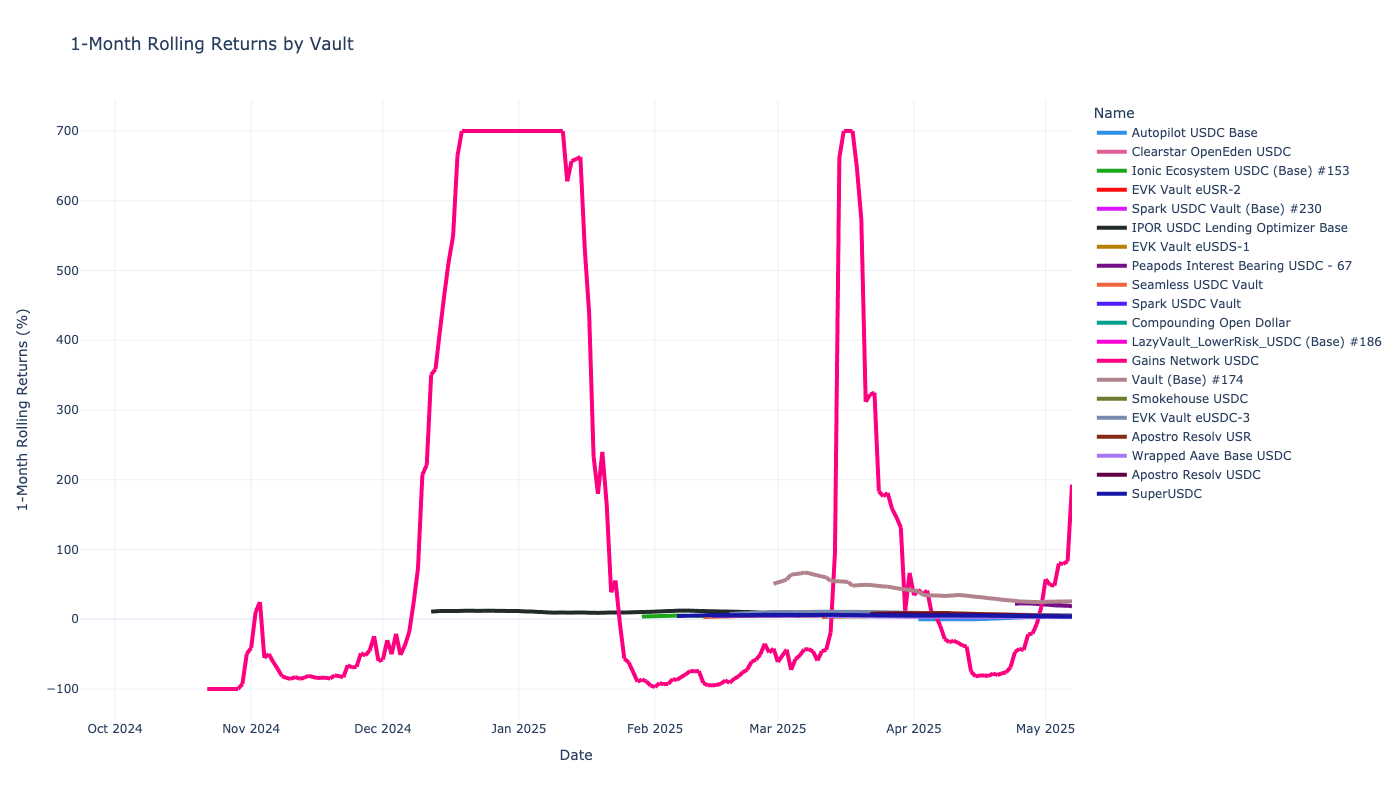

Peak returns by


timestamp                                                    2025-01-02 00:00:00
chain                                                                       8453
address                               0xad20523a7dc37babc1cc74897e4977232b3d02e5
block_number                                                            24529415
share_price                                                                 2.01
total_assets                                                        1,749,304.10
total_supply                                                          869,563.15
performance_fee                                                              NaN
management_fee                                                               NaN
errors                                                                          
id                               8453-0xad20523a7dc37babc1cc74897e4977232b3d02e5
name                                                          Gains Network USDC
event_count                 

In [19]:
import plotly.express as px
from plotly.colors import qualitative 


benchmark_count: int = 20


def calculate_rolling_returns(
    returns_df: pd.DataFrame,
    interesting_vaults: pd.Series | None,
    window: int = 30,  # Bars
    period: pd.Timedelta = pd.Timedelta(days=365),    
    cap: float = None,
    clip_down: float=None,
    clip_up: float=None,
    drop_threshold: float = None,
):
    
    # Limit to benchmarked vaults
    if interesting_vaults is not None:
        df = returns_df[returns_df["id"].isin(interesting_vaults)]
    else:
        df = returns_df
    df = df.reset_index().sort_values(by=["id", "timestamp"])

    # Manually blacklist one vault where we get data until fixed
    df = df[df["name"] != "Revert Lend Arbitrum USDC,"]

    # Limit chart width
    df = df.loc[df["timestamp"] >= (pd.Timestamp.now() - period)]

    # Calculate rollling returns
    df['rolling_1m_returns'] = df.groupby('id')['daily_returns'].transform(
        lambda x: (((1 + x).rolling(window=window).apply(np.prod) - 1) * 100)
    )

    df['rolling_1m_returns_annualized'] = ((1 + df['rolling_1m_returns']/100) ** 12 - 1) * 100

    # When vault launches it has usually near-infinite APY
    # Cap it here so charts are readable
    if cap is not None:
        # Using mask (replaces values WHERE condition is True)
        df['rolling_1m_returns_annualized'] = df['rolling_1m_returns_annualized'].mask(
            (df['rolling_1m_returns_annualized'] > cap) | (df['rolling_1m_returns_annualized'] < -cap), 
            np.nan
        )

    if clip_down is not None:
        df['rolling_1m_returns_annualized'] = df['rolling_1m_returns_annualized'].clip(lower=clip_down)

    if clip_up is not None:
        df['rolling_1m_returns_annualized'] = df['rolling_1m_returns_annualized'].clip(upper=clip_up)

    if drop_threshold is not None:
        # Step 1: Identify vaults with extreme returns
        extreme_return_vaults = returns_df.groupby('name')['daily_returns'].apply(
            lambda x: (x > 1000).any()
        )
        extreme_return_names = extreme_return_vaults[extreme_return_vaults].index.tolist()

        print("Removing extreme return vaults: ", extreme_return_names)

        # Step 2: Filter the DataFrame to exclude these vaults
        df = df[~df['name'].isin(extreme_return_names)]
        
    return df


interesting_vaults = lifetime_data_filtered_df[0:benchmark_count]["id"]
df = rolling_returns_df = all_rolling_returns_df = calculate_rolling_returns(
    returns_df, 
    interesting_vaults=interesting_vaults,
    clip_up=700,
)

# Report manual fee data gathering needed
lack_fees_df = df[df["performance_fee"].isna()]
print(f"We lack perf fee data for {len(lack_fees_df['id'].unique()):,} / {len(interesting_vaults)} vaults")

# display(df.head(2))

fig = px.line(df, 
              x='timestamp', 
              y='rolling_1m_returns_annualized',
              color='name',
              title='1-Month Rolling Returns by Vault',
              labels={'rolling_1m_returns': '1-Month Rolling Returns (%)',
                     'timestamp': 'Date',
                     'name': 'Name'},
              hover_data=['id'],
              color_discrete_sequence=qualitative.Dark24,
              )

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='1-Month Rolling Returns (%)',
    legend_title='Name',
    hovermode='closest',
    template=pio.templates.default,
)

fig.update_traces(line=dict(width=4))


fig.show()

max_row = df.loc[df['rolling_1m_returns'].idxmax()]
print("Peak returns by")
display(max_row)

### All vaults, excluding volatile

- Exclude gDAI to see other vaults better in the chart



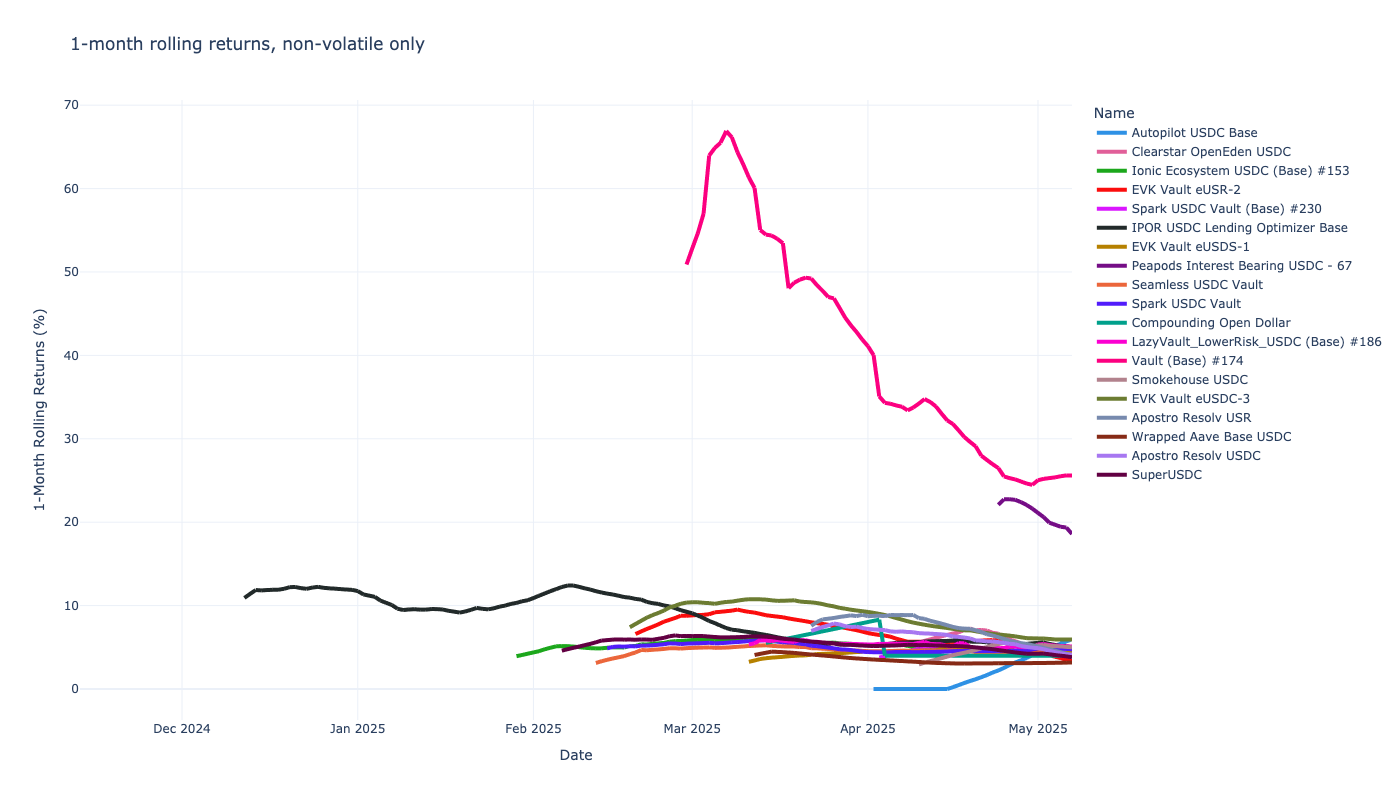

Peak returns by


timestamp                                                    2025-01-02 00:00:00
chain                                                                       8453
address                               0xad20523a7dc37babc1cc74897e4977232b3d02e5
block_number                                                            24529415
share_price                                                                 2.01
total_assets                                                        1,749,304.10
total_supply                                                          869,563.15
performance_fee                                                              NaN
management_fee                                                               NaN
errors                                                                          
id                               8453-0xad20523a7dc37babc1cc74897e4977232b3d02e5
name                                                          Gains Network USDC
event_count                 

In [20]:
# TODO: Fix with better filtering
non_volatile_df = all_rolling_returns_df
non_volatile_df = non_volatile_df[non_volatile_df["name"].str.contains("Gains") == False]
non_volatile_df = non_volatile_df[non_volatile_df["name"].str.contains("ostium") == False]

fig = px.line(non_volatile_df, 
              x='timestamp', 
              y='rolling_1m_returns_annualized',
              color='name',
              title='1-month rolling returns, non-volatile only',
              labels={'rolling_1m_returns': '1-Month Rolling Returns (%)',
                     'timestamp': 'Date',
                     'name': 'Name'},
              hover_data=['id'],
              color_discrete_sequence=qualitative.Dark24,
              )

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='1-Month Rolling Returns (%)',
    legend_title='Name',
    hovermode='closest',
    template=pio.templates.default
)

fig.update_traces(line=dict(width=4))

fig.show()

max_row = df.loc[df['rolling_1m_returns'].idxmax()]
print("Peak returns by")
display(max_row)

### All vaults, volatile only

- Benchmark market-making and such vaults against each other across chains.

Top volatile vaults


Annualised return Lifetime return Last 3M return  \
name                                                                  
Gains Network USDC           -96.42%         -87.27%         29.68%   

                   Last 3M months volatility Deposit token Chain  \
name                                                               
Gains Network USDC                    0.0165          USDC  Base   

                    Peak TVL USD  Current TVL USD  Age (years) Management fee  \
name                                                                            
Gains Network USDC  4,936,901.59     2,675,945.03         0.62        unknown   

                   perf_fee Deposit/redeem count            Protocol  \
name                                                                   
Gains Network USDC  unknown                1,477  <unknown ERC-4626>   

                                                                 id  \
name                                                                  
Gains Network USDC  8453-0xad20523a7dc37babc1cc74897e4977232b3d02e5   

                   Last 3M return First deposit Last deposit  
name                                                          
Gains Network USDC         17.45%    2025-02-14   2025-05-07

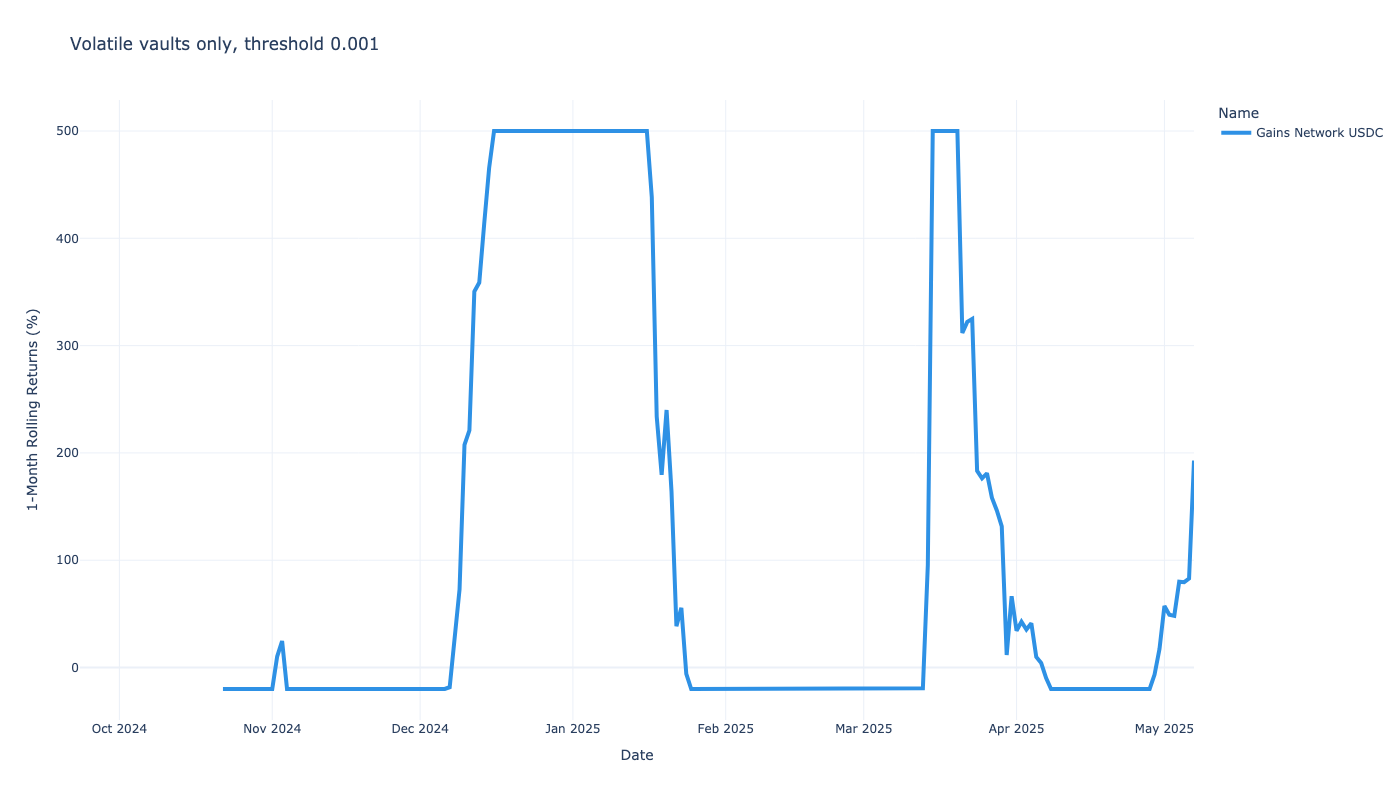

In [21]:
volatility_threshold = 0.001
benchmark_count = 20
nav_threshold = 25_000
lifetime_data_filtered_df = lifetime_data_df[
    (lifetime_data_df['current_nav'] >= nav_threshold) &
    (lifetime_data_df['event_count'] >= event_threshold)
]

lifetime_data_filtered_df = lifetime_data_df
lifetime_data_filtered_df = lifetime_data_filtered_df[lifetime_data_filtered_df['current_nav'] > nav_threshold]
lifetime_data_filtered_df = lifetime_data_filtered_df.sort_values(by='three_months_cagr', ascending=False)

lifetime_data_filtered_df = lifetime_data_filtered_df.iloc[0:benchmark_count]
interesting_vaults = lifetime_data_filtered_df[lifetime_data_filtered_df['three_months_volatility'] > volatility_threshold]

interesting_vaults = interesting_vaults.iloc[0:benchmark_count]


rolling_returns_df = calculate_rolling_returns(
    returns_df, 
    interesting_vaults=set(interesting_vaults["id"]),
    clip_down=-20,
    clip_up=500,
    window=30,
    )

print("Top volatile vaults")
display(format_lifetime_table(interesting_vaults))

fig = px.line(rolling_returns_df, 
              x='timestamp', 
              y='rolling_1m_returns_annualized',
              color='name',
              title=f'Volatile vaults only, threshold {volatility_threshold}',
              labels={'rolling_1m_returns': '1-Month Rolling Returns (%)',
                     'timestamp': 'Date',
                     'name': 'Name'},
              hover_data=['id'],
              color_discrete_sequence=qualitative.Dark24,
              )


fig.update_layout(
    xaxis_title='Date',
    yaxis_title='1-Month Rolling Returns (%)',
    legend_title='Name',
    hovermode='closest',
    template=pio.templates.default
)

fig.update_traces(line=dict(width=4))

fig.show()



### All vaults, volatile only, filtering extreme results

- Better representative of volatile vaults with more NAV filering
- Remove vaults with seemingly bad returns
- TODO: This seems be very difficult to analyse

Total 2 interesting volatile vaults: ['Gains Network USDC', 'kUSDC']
Removing extreme return vaults:  []
Top 20 volatile vaults by the lat returns 


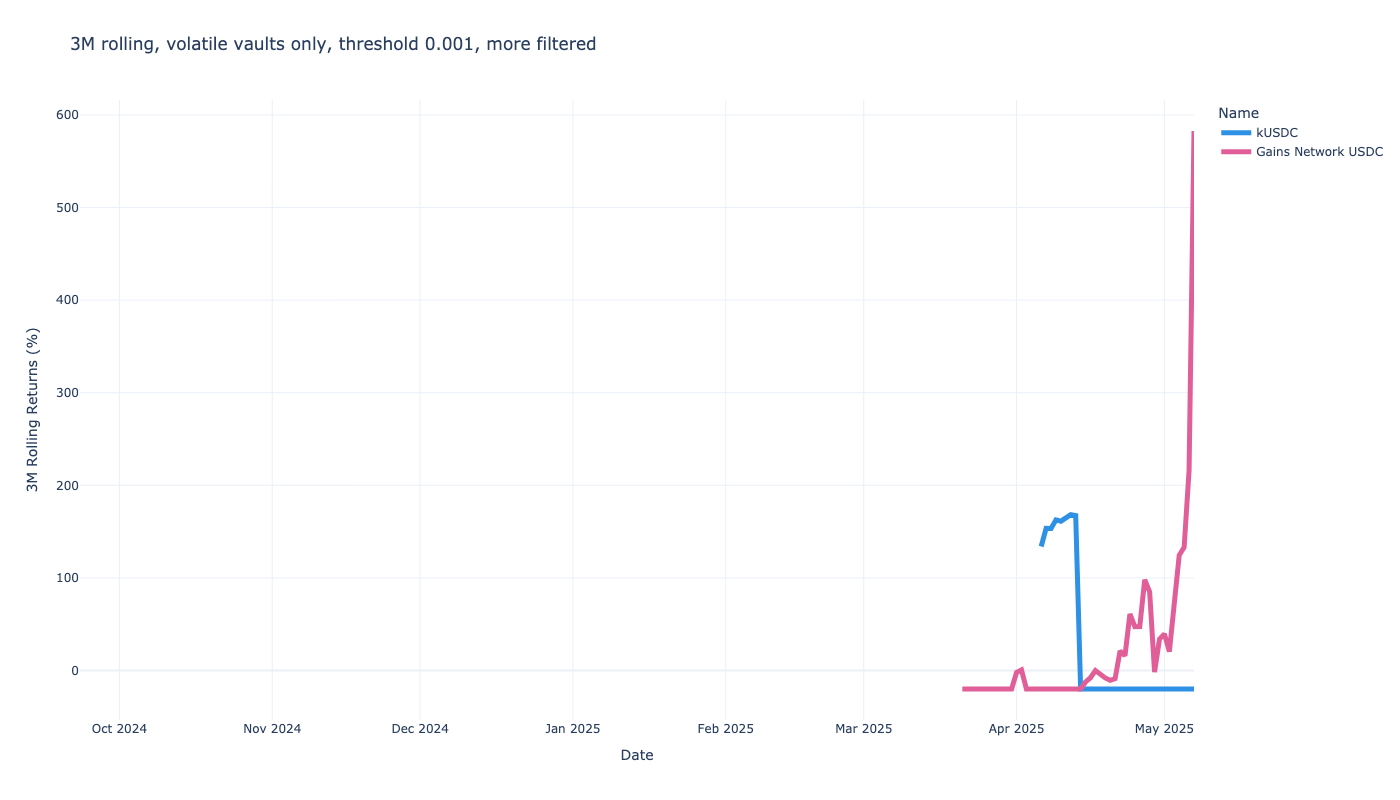

In [22]:
bad_returns_threshold = 900
benchmark_count = 15  # By the last 1-month returns
nav_threshold = 500_000

lifetime_data_filtered_df = lifetime_data_df
lifetime_data_filtered_df = lifetime_data_filtered_df[lifetime_data_filtered_df['current_nav'] > nav_threshold]
lifetime_data_filtered_df = lifetime_data_filtered_df.sort_values(by='three_months_cagr', ascending=False)

# lifetime_data_filtered_df = lifetime_data_filtered_df.iloc[0:benchmark_count]
interesting_vaults = lifetime_data_filtered_df[lifetime_data_filtered_df['three_months_volatility'] > volatility_threshold]

# display(interesting_vaults)

print(f"Total {len(interesting_vaults)} interesting volatile vaults: {interesting_vaults.index.tolist()}")

interesting_vaults = interesting_vaults.iloc[0:benchmark_count]

rolling_returns_df = calculate_rolling_returns(
    returns_df, 
    interesting_vaults=interesting_vaults["id"],
    clip_down=-20,
    clip_up=700,
    window=180,
    drop_threshold=100,
    )


print("Top 20 volatile vaults by the lat returns ")

fig = px.line(rolling_returns_df, 
              x='timestamp', 
              y='rolling_1m_returns_annualized',
              color='name',
              title=f'3M rolling, volatile vaults only, threshold {volatility_threshold}, more filtered',
              labels={'rolling_1m_returns': '1-Month Rolling Returns (%)',
                     'timestamp': 'Date',
                     'name': 'Name'},
              hover_data=['id'],
              color_discrete_sequence=qualitative.Dark24,
              )


fig.update_layout(
    xaxis_title='Date',
    yaxis_title='3M Rolling Returns (%)',
    legend_title='Name',
    hovermode='closest',
    template=pio.templates.default
)

fig.update_traces(line=dict(width=5))

fig.show()


## Top vaults by chain

- Show 1 month rolling returns of top vaults for all chains chain


### Base

Base: Displaying top 5 vaults based on three months returns, total 10 interesting vaults on this chain


Annualised return Lifetime return  \
name                                                                   
Vault (Base) #174                             39.11%           9.16%   
Gains Network USDC                           -96.42%         -87.27%   
Peapods Interest Bearing USDC - 15            25.21%           5.57%   
Peapods Interest Bearing USDC - 31            23.82%           5.22%   
Peapods Interest Bearing USDC - 67            20.54%           2.17%   

                                   Last 3M return Last 3M months volatility  \
name                                                                          
Vault (Base) #174                          31.65%                    0.0005   
Gains Network USDC                         29.68%                    0.0165   
Peapods Interest Bearing USDC - 15         24.13%                    0.0006   
Peapods Interest Bearing USDC - 31         22.62%                    0.0004   
Peapods Interest Bearing USDC - 67         20.54%                    0.0002   

                                    Peak TVL USD  Current TVL USD  \
name                                                                
Vault (Base) #174                   1,846,222.49     1,846,222.49   
Gains Network USDC                  4,936,901.59     2,675,945.03   
Peapods Interest Bearing USDC - 15     91,617.57        67,426.33   
Peapods Interest Bearing USDC - 31     32,025.43        25,438.60   
Peapods Interest Bearing USDC - 67    168,233.52       140,297.39   

                                    Age (years) Management fee perf_fee  \
name                                                                      
Vault (Base) #174                          0.27        unknown  unknown   
Gains Network USDC                         0.62        unknown  unknown   
Peapods Interest Bearing USDC - 15         0.24        unknown  unknown   
Peapods Interest Bearing USDC - 31         0.24        unknown  unknown   
Peapods Interest Bearing USDC - 67         0.11        unknown  unknown   

                                   Deposit/redeem count            Protocol  \
name                                                                          
Vault (Base) #174                                 1,055  <unknown ERC-4626>   
Gains Network USDC                                1,477  <unknown ERC-4626>   
Peapods Interest Bearing USDC - 15               11,285             Peapods   
Peapods Interest Bearing USDC - 31                1,016             Peapods   
Peapods Interest Bearing USDC - 67                1,513             Peapods   

                                                                                 id  \
name                                                                                  
Vault (Base) #174                   8453-0xb99b6df96d4d5448cc0a5b3e0ef7896df9507cf5   
Gains Network USDC                  8453-0xad20523a7dc37babc1cc74897e4977232b3d02e5   
Peapods Interest Bearing USDC - 15  8453-0x6ea0bfff586f2f226c80cc98275b810d2cd95771   
Peapods Interest Bearing USDC - 31  8453-0xda1d377432caf3acd0c01788edc198219a0fa60d   
Peapods Interest Bearing USDC - 67  8453-0x5f6511489c9e770a07fb1ae2969abe350a3d2cf4   

                                   Last 3M return First deposit Last deposit  
name                                                                          
Vault (Base) #174                           7.58%    2025-02-14   2025-05-07  
Gains Network USDC                         17.45%    2025-02-14   2025-05-07  
Peapods Interest Bearing USDC - 15          5.35%    2025-02-14   2025-05-07  
Peapods Interest Bearing USDC - 31          4.98%    2025-02-14   2025-05-07  
Peapods Interest Bearing USDC - 67          2.17%    2025-03-26   2025-05-07

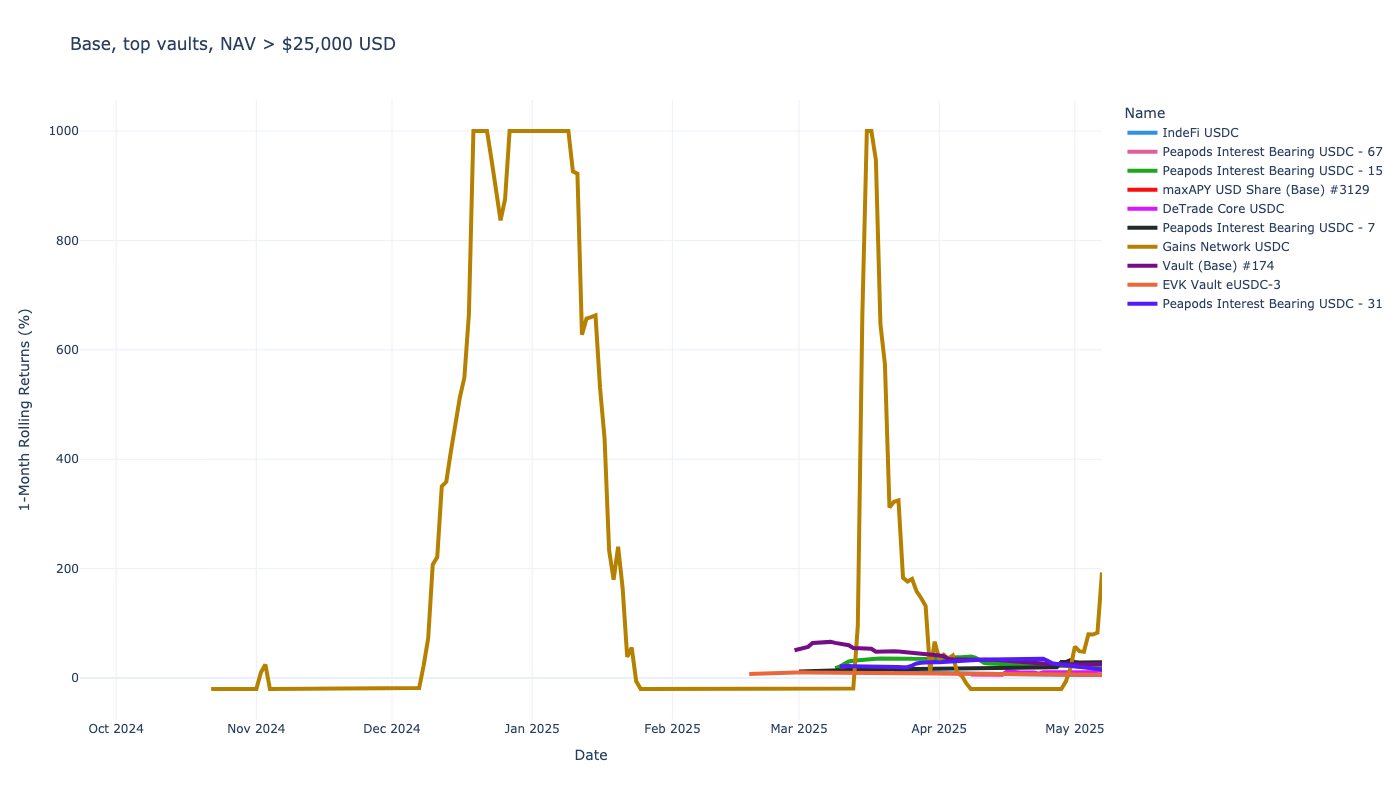

Base: Displaying top 5 non-volatile vaults based on three months returns, total 10 interesting vaults on this chain


Annualised return Lifetime return  \
name                                                                   
Vault (Base) #174                             39.11%           9.16%   
Peapods Interest Bearing USDC - 15            25.21%           5.57%   
Peapods Interest Bearing USDC - 31            23.82%           5.22%   
Peapods Interest Bearing USDC - 67            20.54%           2.17%   
Peapods Interest Bearing USDC - 7             19.28%           4.74%   

                                   Last 3M return Last 3M months volatility  \
name                                                                          
Vault (Base) #174                          31.65%                    0.0005   
Peapods Interest Bearing USDC - 15         24.13%                    0.0006   
Peapods Interest Bearing USDC - 31         22.62%                    0.0004   
Peapods Interest Bearing USDC - 67         20.54%                    0.0002   
Peapods Interest Bearing USDC - 7          17.94%                    0.0008   

                                    Peak TVL USD  Current TVL USD  \
name                                                                
Vault (Base) #174                   1,846,222.49     1,846,222.49   
Peapods Interest Bearing USDC - 15     91,617.57        67,426.33   
Peapods Interest Bearing USDC - 31     32,025.43        25,438.60   
Peapods Interest Bearing USDC - 67    168,233.52       140,297.39   
Peapods Interest Bearing USDC - 7      55,284.01        41,976.87   

                                    Age (years) Management fee perf_fee  \
name                                                                      
Vault (Base) #174                          0.27        unknown  unknown   
Peapods Interest Bearing USDC - 15         0.24        unknown  unknown   
Peapods Interest Bearing USDC - 31         0.24        unknown  unknown   
Peapods Interest Bearing USDC - 67         0.11        unknown  unknown   
Peapods Interest Bearing USDC - 7          0.26        unknown  unknown   

                                   Deposit/redeem count            Protocol  \
name                                                                          
Vault (Base) #174                                 1,055  <unknown ERC-4626>   
Peapods Interest Bearing USDC - 15               11,285             Peapods   
Peapods Interest Bearing USDC - 31                1,016             Peapods   
Peapods Interest Bearing USDC - 67                1,513             Peapods   
Peapods Interest Bearing USDC - 7                   313             Peapods   

                                                                                 id  \
name                                                                                  
Vault (Base) #174                   8453-0xb99b6df96d4d5448cc0a5b3e0ef7896df9507cf5   
Peapods Interest Bearing USDC - 15  8453-0x6ea0bfff586f2f226c80cc98275b810d2cd95771   
Peapods Interest Bearing USDC - 31  8453-0xda1d377432caf3acd0c01788edc198219a0fa60d   
Peapods Interest Bearing USDC - 67  8453-0x5f6511489c9e770a07fb1ae2969abe350a3d2cf4   
Peapods Interest Bearing USDC - 7   8453-0x9c77e29e59ce30445048fa653442ee296442c350   

                                   Last 3M return First deposit Last deposit  
name                                                                          
Vault (Base) #174                           7.58%    2025-02-14   2025-05-07  
Peapods Interest Bearing USDC - 15          5.35%    2025-02-14   2025-05-07  
Peapods Interest Bearing USDC - 31          4.98%    2025-02-14   2025-05-07  
Peapods Interest Bearing USDC - 67          2.17%    2025-03-26   2025-05-07  
Peapods Interest Bearing USDC - 7           4.43%    2025-02-14   2025-05-07

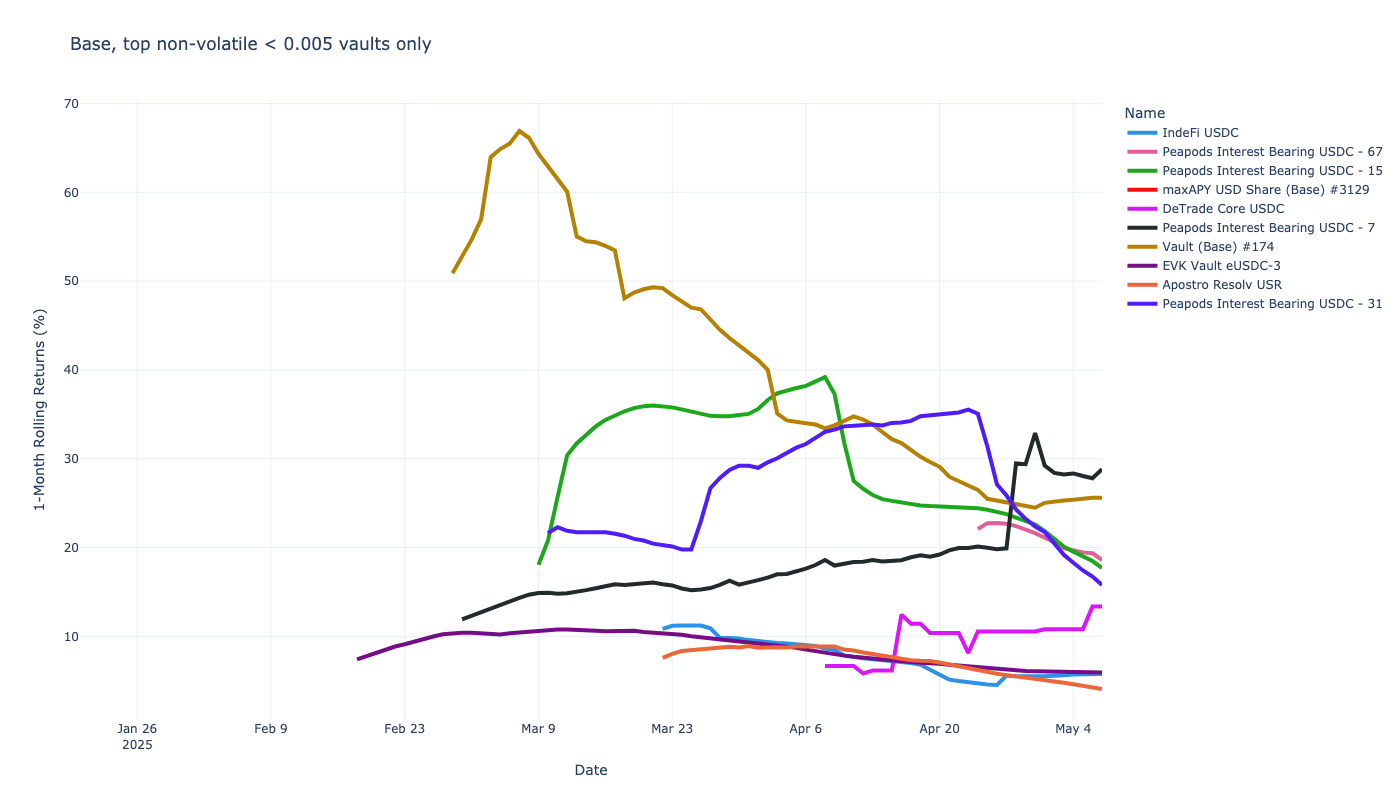

In [23]:
from IPython.display import Markdown

benchmark_count = 10
min_nav = 25_000
volatility_threshold = 0.005

def _draw_chain_top_vaults_chart(interesting_vaults: pd.Series, title: str):
    """Draw 1 months return chart for specific vaults"""
    df = calculate_rolling_returns(
        returns_df, 
        interesting_vaults=interesting_vaults, 
        clip_up=1000,
        clip_down=-20,
        )

    # Remove entries with all zero returns.
    # TODO: Get rid of Hyped USDB and others with zero returns still showing up in the charts
    mask = df.groupby('name')['daily_returns'].transform(lambda x: (x != 0).any())
    filtered_returns_df = df[mask]
    
    if len(df) == 0:
        print(f"No vaults to display: {title}")
        return

    # 
    
    fig = px.line(filtered_returns_df, 
                  x='timestamp', 
                  y='rolling_1m_returns_annualized',
                  color='name',
                  title=title, 
                  labels={'rolling_1m_returns': '1-Month Rolling Returns (%)',
                         'timestamp': 'Date',
                         'name': 'Name'},
                  hover_data=['id'],
                  color_discrete_sequence=qualitative.Dark24,
                  )

    fig.update_layout(
        xaxis_title='Date',
        yaxis_title='1-Month Rolling Returns (%)',
        legend_title='Name',
        hovermode='closest',
        template=pio.templates.default,
    )
    fig.update_traces(line=dict(width=4))
    fig.show()    

# Do 2 charts per chain
for chain_name in lifetime_data_df["chain"].unique():

    display(Markdown(f"### {chain_name}"))
    
    # chain_df = df[df["chain"] == chain_id]
    lifetime_data_filtered_df = lifetime_data_df[lifetime_data_df['chain'] == chain_name]
    
    lifetime_data_filtered_df = lifetime_data_filtered_df[lifetime_data_filtered_df["current_nav"] >= min_nav]
    lifetime_data_filtered_df = lifetime_data_filtered_df.sort_values(by='three_months_cagr', ascending=False)
 
    lifetime_data_filtered_slice_df = lifetime_data_filtered_df[0:benchmark_count]
    interesting_vaults = lifetime_data_filtered_slice_df["id"]
    # Cut off chart at 1000x returns

    # Rearrange columns
    column_to_shift = "three_months_cagr"
    new_order = [column_to_shift] + [col for col in lifetime_data_filtered_df.columns if col != column_to_shift]
    lifetime_data_filtered_df = lifetime_data_filtered_df[new_order]

    print(f"{chain_name}: Displaying top 5 vaults based on three months returns, total {len(interesting_vaults)} interesting vaults on this chain")
    lifetime_data_filtered_slice_df = lifetime_data_filtered_slice_df.drop(columns=["chain", "denomination"])
    if len(lifetime_data_filtered_slice_df) > 0:
        display(format_lifetime_table(lifetime_data_filtered_slice_df[0:5]))

    _draw_chain_top_vaults_chart(interesting_vaults, title=f'{chain_name}, top vaults, NAV > ${min_nav:,} USD',)
   

    #
    # Non-volatile
    # 

    print(f"{chain_name}: Displaying top 5 non-volatile vaults based on three months returns, total {len(interesting_vaults)} interesting vaults on this chain")
    lifetime_data_filtered_df = lifetime_data_filtered_df[lifetime_data_filtered_df["three_months_volatility"] < 0.005]
    lifetime_data_filtered_slice_df = lifetime_data_filtered_slice_df[lifetime_data_filtered_slice_df["three_months_volatility"] < 0.005]
    if len(lifetime_data_filtered_slice_df) > 0:
        display(format_lifetime_table(lifetime_data_filtered_slice_df[0:5]))
    
    lifetime_data_filtered_slice_df = lifetime_data_filtered_df[0:benchmark_count]
    interesting_vaults = lifetime_data_filtered_slice_df["id"]
    # Cut off chart at 1000x returns
    df = calculate_rolling_returns(
        returns_df, 
        interesting_vaults=interesting_vaults, 
        clip_up=1000,
        clip_down=-20,
        )

    # Rearrange columns
    column_to_shift = "three_months_cagr"
    new_order = [column_to_shift] + [col for col in lifetime_data_filtered_df.columns if col != column_to_shift]
    lifetime_data_filtered_df = lifetime_data_filtered_df[new_order]

    _draw_chain_top_vaults_chart(interesting_vaults, title=f'{chain_name}, top non-volatile < {volatility_threshold} vaults only',)


## Analyse a single picked vault

- Get equity curve and portfolio comparison metrics for the top vault that still has NAV left
- We pick Clearstar OpenEden RWA vault for the analysis

### Top vault: Share price chart

- Show the share price of the chosen vault
- We can calculate returns, or APY % from the share price



In [24]:
top_vault_id = "8453-0x1d3b1cd0a0f242d598834b3f2d126dc6bd774657"
name = vaults_by_id[top_vault_id]['Name'] 
vault_df = returns_df.loc[returns_df["id"] == top_vault_id]
daily_returns = returns_df.loc[returns_df["id"] == top_vault_id]["daily_returns"]
vault_metadata = vaults_by_id[top_vault_id]

print(f"Top vault is {name}: {top_vault_id}, having {len(daily_returns):,} daily returns rows")

Top vault is Clearstar OpenEden USDC: 8453-0x1d3b1cd0a0f242d598834b3f2d126dc6bd774657, having 58 daily returns rows


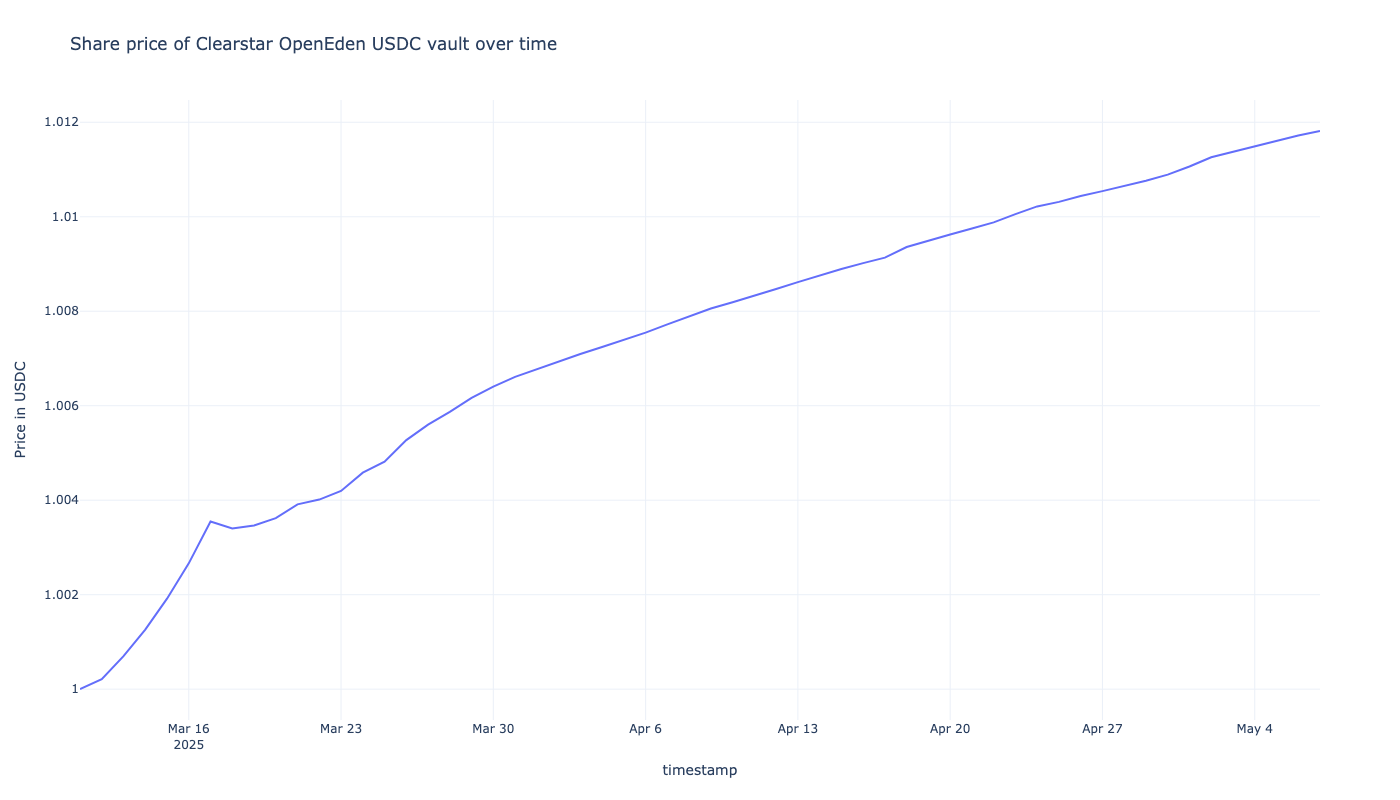

In [25]:
import plotly.express as px
price_series = vault_df["share_price"]

fig = px.line( 
    price_series, 
    title=f"Share price of {name} vault over time"
)
fig.update_layout(yaxis_title=f"Price in {vault_metadata['Denomination']}")
fig.update_layout(showlegend=False)
fig.show()

### Top vault: Net asset value

- What is the value of the all assets locked in the vault
- [Sometimes referred as TVL](https://tradingstrategy.ai/glossary/total-value-locked-tvl)



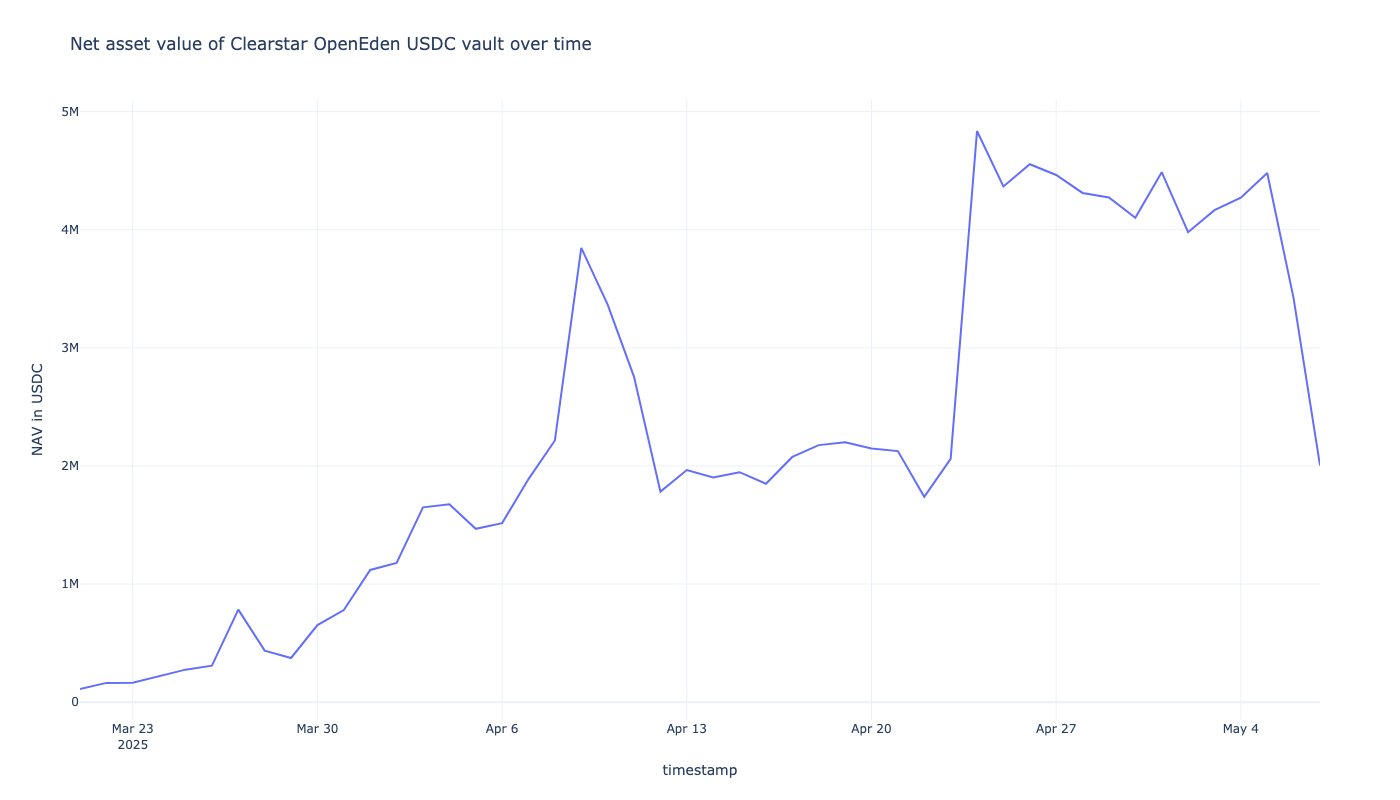

In [26]:
import plotly.express as px
nav_series = vault_df["total_assets"]

# Remove the uninteresting period when NAV is low
min_nav_threshold = 100_000
nav_series = nav_series[nav_series > min_nav_threshold]

fig = px.line( 
    nav_series, 
    title=f"Net asset value of {name} vault over time"
)
fig.update_layout(yaxis_title=f"NAV in {vault_metadata['Denomination']}")
fig.update_layout(showlegend=False)
fig.show()

### Top vault: Performance metrics

- Portfolio performance metrics for this vault

In [27]:
import warnings

with warnings.catch_warnings():  #  DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
    warnings.simplefilter(action='ignore', category=FutureWarning)  # yfinance: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
    try:
        # quantstats compatibility hack for IPython 8.x, ZMQInteractiveShell error
        # https://stackoverflow.com/a/15898875/315168
        get_ipython().magic = lambda x: x
        import quantstats
    except ImportError as e:
        quantstats = None
        

if quantstats:
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=RuntimeWarning)
        warnings.simplefilter(action='ignore', category=FutureWarning)
        
        metrics = quantstats.reports.metrics
        performance_metrics_df = metrics(
            daily_returns,
            benchmark=None,
            as_pct=display,  # QuantStats codebase is a mess
            periods_per_year=365,
            mode="full",
            display=False,
            internal=True,
        )    
    print(f"Portfolio performance metrics for {name} vault") 
    performance_metrics_df.rename(columns={"Strategy": name}, inplace=True)
    display(performance_metrics_df)
else:
    print("To show the portfolio performance metrics install quantstats: pip install quantstats")
    
    

Portfolio performance metrics for Clearstar OpenEden USDC vault


Clearstar OpenEden USDC
Start Period                           2025-03-11
End Period                             2025-05-07
Risk-Free Rate                               0.0%
Time in Market                              83.0%
Cumulative Return                           0.82%
CAGR﹪                                       3.66%
Sharpe                                      28.42
Prob. Sharpe Ratio                         100.0%
Smart Sharpe                                12.42
Sortino                                         -
Smart Sortino                                   -
Sortino/√2                                      -
Smart Sortino/√2                                -
Omega                                           -
Max Drawdown                                    %
Longest DD Days                                 -
Volatility (ann.)                           0.18%
Calmar                                          -
Skew                                         0.78
Kurtosis                                     1.76
Expected Daily                              0.01%
Expected Monthly                            0.27%
Expected Yearly                             0.82%
Kelly Criterion                                 -
Risk of Ruin                                 0.0%
Daily Value-at-Risk                         -0.0%
Expected Shortfall (cVaR)                   -0.0%
Max Consecutive Wins                           48
Max Consecutive Losses                          0
Gain/Pain Ratio                                 -
Gain/Pain (1M)                                  -
Payoff Ratio                                    -
Profit Factor                                   -
Common Sense Ratio                              -
CPC Index                                       -
Tail Ratio                                      -
Outlier Win Ratio                            2.96
Outlier Loss Ratio                              -
MTD                                         0.09%
3M                                          0.82%
6M                                          0.82%
YTD                                         0.82%
1Y                                          0.82%
3Y (ann.)                                   3.66%
5Y (ann.)                                   3.66%
10Y (ann.)                                  3.66%
All-time (ann.)                             3.66%
Best Day                                    0.05%
Worst Day                                    0.0%
Best Month                                  0.43%
Worst Month                                 0.09%
Best Year                                   0.82%
Worst Year                                  0.82%
Recovery Factor                                 -
Ulcer Index                                   0.0
Serenity Index                                  -
Avg. Up Month                               0.27%
Avg. Down Month                                 -
Win Days                                   100.0%
Win Month                                  100.0%
Win Quarter                                100.0%
Win Year                                   100.0%
Avg. Drawdown Days                              -

## Analyse other top vaults

- Check some other top vaults for benchmark
- We see from the share price


In [28]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


def analyse_vault(id: str):

    name = vaults_by_id[id]['Name'] 

    vault_df = returns_df.loc[returns_df["id"] == id]
    daily_returns = returns_df.loc[returns_df["id"] == id]["daily_returns"]
    vault_metadata = vaults_by_id[id]
    print(f"Examining vault {name}: {id}, having {len(daily_returns):,} daily returns rows")    
    nav_series = vault_df["total_assets"]
    
    price_series = vault_df["share_price"]

    # Calculate cumulative returns (what $1 would grow to)
    cumulative_returns = (1 + daily_returns).cumprod()

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add cumulative returns trace on a separate y-axis (share same axis as share price)
    fig.add_trace(
        go.Scatter(
            x=cumulative_returns.index,
            y=cumulative_returns.values,
            name="Cumulative returns (cleaned)",
            line=dict(color='darkgreen', width=4),
            opacity=0.75
        ),
        secondary_y=False,
    )    

    # Add share price trace on primary y-axis
    fig.add_trace(
        go.Scatter(
            x=price_series.index, 
            y=price_series.values, 
            name="Share Price",
            line=dict(color='green', width=4, dash='dash'),
            opacity=0.75  

        ),
        secondary_y=False,
    )

    # Add NAV trace on secondary y-axis
    fig.add_trace(
        go.Scatter(
            x=nav_series.index, 
            y=nav_series.values, 
            name="TVL",
            line=dict(color='blue', width=4),
            opacity=0.75  

        ),
        secondary_y=True,
    )




    # Set titles and labels
    fig.update_layout(
        title_text=f"{name} - Returns TVL and share price",
        hovermode="x unified",
        template=pio.templates.default,
        showlegend=True,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="center",
            x=0.5
        )
    )    

    # Set y-axes titles
    fig.update_yaxes(title_text=f"Share Price ({vault_metadata['Denomination']})", secondary_y=False)
    fig.update_yaxes(title_text=f"TVL ({vault_metadata['Denomination']})", secondary_y=True)

    # Show chart
    fig.show()

    # Show portfolio metrics
    if quantstats:
        with warnings.catch_warnings():
            warnings.simplefilter(action='ignore', category=RuntimeWarning)
            warnings.simplefilter(action='ignore', category=FutureWarning)
            
            metrics = quantstats.reports.metrics
            performance_metrics_df = metrics(
                daily_returns,
                benchmark=None,
                as_pct=display,  # QuantStats codebase is a mess
                periods_per_year=365,
                mode="simple",
                display=False,
                internal=True,
            )        
            performance_metrics_df.rename(columns={"Strategy": name}, inplace=True)
            display(performance_metrics_df)



    

### Gains USDC on Polygon

- Gains market making vault
- https://gains.trade/vaults/gUSDC

Examining vault Gains Network USDC (Polygon) #2422: 137-0x29019fe2e72e8d4d2118e8d0318bef389ffe2c81, having 0 daily returns rows


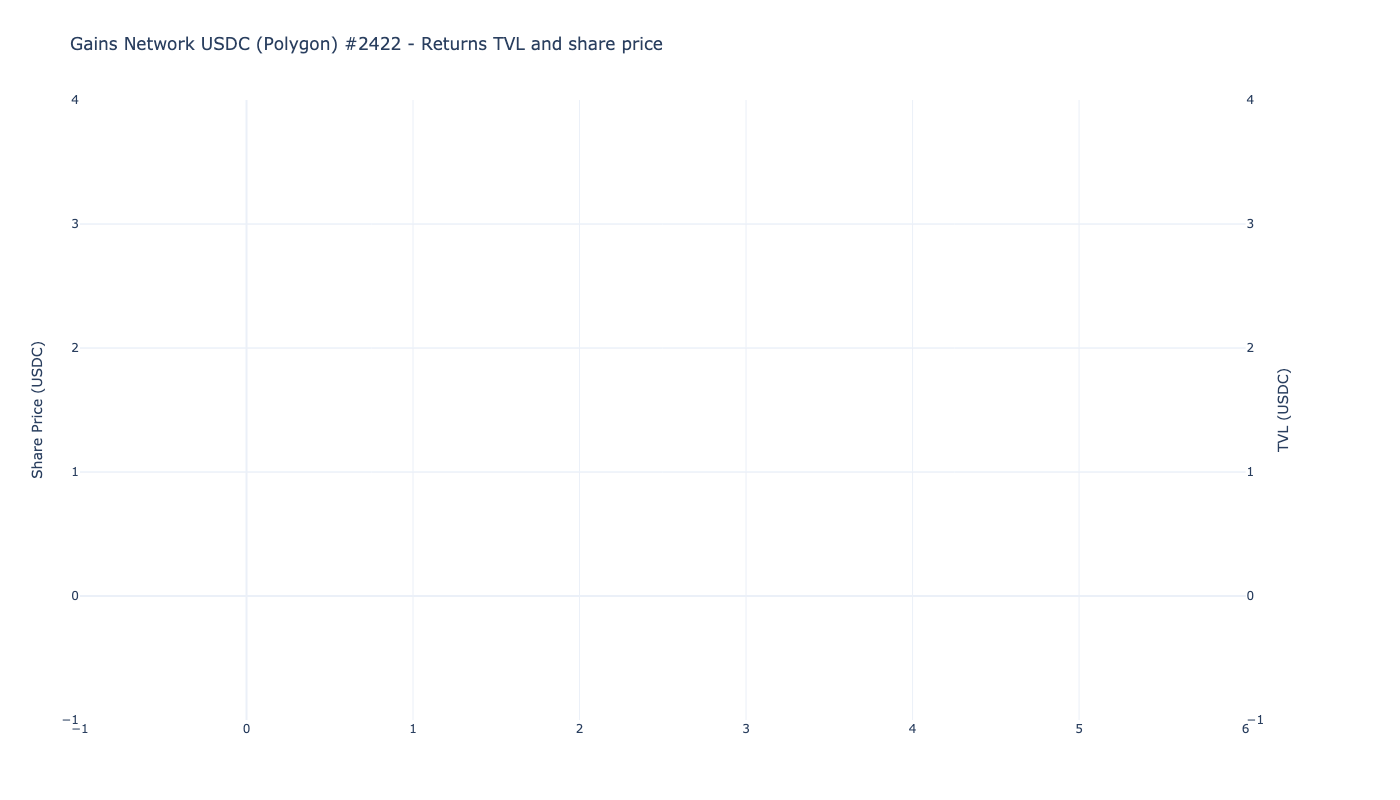

IndexError: index 0 is out of bounds for axis 0 with size 0

In [29]:
analyse_vault("137-0x29019fe2e72e8d4d2118e8d0318bef389ffe2c81")

### USDC to yvUSDS Farmer by Yearn

https://yearn.fi/vaults/1/0x602DA189F5aDa033E9aC7096Fc39C7F44a77e942
    ,


In [ ]:
analyse_vault("1-0x602da189f5ada033e9ac7096fc39c7f44a77e942")

### Staked avUSD by Avant

https://app.avantprotocol.com/stake



In [ ]:
analyse_vault("43114-0x06d47f3fb376649c3a9dafe069b3d6e35572219e")

### Morpho Steakhouse USDT Compounder by Yearn

https://yearn.fi/vaults/1/0x0a4ea2bDe8496a878a7ca2772056a8e6fe3245c5,


In [ ]:
vault_id = "1-0x0a4ea2bde8496a878a7ca2772056a8e6fe3245c5"
analyse_vault(vault_id)

vault_returns_df = returns_df.loc[returns_df["id"] == vault_id]

# Identify the columns you want to move to the front
columns_to_move = ['total_assets', 'daily_returns', 'dynamic_tvl_threshold', 'tvl_filtering_mask']
all_columns = vault_returns_df.columns.tolist()
remaining_columns = [col for col in all_columns if col not in columns_to_move]
new_column_order = columns_to_move + remaining_columns
vault_returns_df = vault_returns_df[new_column_order]

display(vault_returns_df.loc[pd.Timestamp("2025-02-10"):pd.Timestamp("2025-02-28")])



### kBOX (Unknown)

- Unknown


In [ ]:
analyse_vault("56-0x6e7a6eb5feec64bf6401a744757aba89c5c7e813")

### Harvest finance ZKSync

https://app.harvest.finance/zksync/0x1B51eA0e4EDf4fac001D3CD55d3fAFc1D1f02f26#details



In [ ]:
analyse_vault("324-0x1b51ea0e4edf4fac001d3cd55d3fafc1d1f02f26")

### 40acres on Optimism

https://www.40acres.finance/

In [ ]:
analyse_vault("10-0x08dcdbf7bade91ccd42cb2a4ea8e5d199d285957")

### Ostium market making vault

- On Arbitrum
- https://ostium.app/vault



In [ ]:
analyse_vault("42161-0x20d419a8e12c45f88fda7c5760bb6923cee27f98")

### Aave V3 USDS Lender by Yearn 

- https://yearn.fi/vaults/1/0x832c30802054F60f0CeDb5BE1F9A0e3da2a0Cab4


In [ ]:
analyse_vault("1-0x832c30802054f60f0cedb5be1f9a0e3da2a0cab4")